# Model Prediction Analysis for Arrythmia and Heart Damage of Cadiac Organoids

This notebook trains XGBoost models using **only** the PK-PD elimination equation coefficients to predict:
- **Arrhythmia** (binary: true/false)
- **Heart Damage** (binary: true/false)  
- **Concern** (multiclass: most/less/no)

Each step is shown in separate cells so you can validate the data as we go.


## Installation Instructions

**If you get import errors, run the cell below to install all required packages.**

Alternatively, you can install from the command line:
```bash
pip install pandas numpy scikit-learn xgboost joblib openpyxl matplotlib ipykernel jupyter
```


In [2]:
# Install required packages (run this cell first if you get import errors)
# Uncomment the line below and run this cell to install all dependencies

# !pip install pandas numpy scikit-learn xgboost joblib openpyxl matplotlib ipykernel

# Or install all at once:
# !pip install pandas numpy scikit-learn xgboost joblib openpyxl matplotlib ipykernel jupyter

print("If you see import errors, uncomment the pip install line above and run this cell.")
print("Required packages:")
print("  - pandas (for data manipulation)")
print("  - numpy (for numerical operations)")
print("  - scikit-learn (for machine learning)")
print("  - xgboost (for XGBoost models)")
print("  - joblib (for saving models)")
print("  - openpyxl (for reading Excel files)")
print("  - matplotlib (for plotting, optional)")
print("  - ipykernel (for Jupyter notebook support)")


If you see import errors, uncomment the pip install line above and run this cell.
Required packages:
  - pandas (for data manipulation)
  - numpy (for numerical operations)
  - scikit-learn (for machine learning)
  - xgboost (for XGBoost models)
  - joblib (for saving models)
  - openpyxl (for reading Excel files)
  - matplotlib (for plotting, optional)
  - ipykernel (for Jupyter notebook support)


In [3]:
# Dependencies: None (initial setup cell)
# Cell 1: Imports and Setup
import pandas as pd
import numpy as np
import sys
import os
import random
from pathlib import Path
import seaborn as sns

# Find project root - look for EQN_Coefficients directory (current workspace structure)
current_dir = Path.cwd()

# Strategy 1: Check if we're in Prediction_Models directory
if current_dir.name == 'Prediction_Models':
    PROJECT_ROOT = current_dir.parent
# Strategy 2: Check if EQN_Coefficients exists in current directory
elif (current_dir / 'EQN_Coefficients').exists():
    PROJECT_ROOT = current_dir
# Strategy 3: Check if EQN_Coefficients exists one level up
elif (current_dir.parent / 'EQN_Coefficients').exists():
    PROJECT_ROOT = current_dir.parent
# Strategy 4: Check if we're in a subdirectory and need to go up
elif (current_dir.parent.parent / 'EQN_Coefficients').exists():
    PROJECT_ROOT = current_dir.parent.parent
else:
    # Default: assume current directory is project root
    PROJECT_ROOT = current_dir

# Add Prediction_Models to path for utils import
prediction_models_dir = PROJECT_ROOT / 'Prediction_Models'
if prediction_models_dir.exists():
    sys.path.insert(0, str(prediction_models_dir))

try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except ImportError:
    XGBOOST_AVAILABLE = False
    print("Warning: XGBoost not available. Install with: pip install xgboost")

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score
from sklearn.svm import SVC  # For Gaussian Kernel (Heart Damage)
from sklearn.linear_model import LogisticRegression  # For Concern
from sklearn.ensemble import RandomForestClassifier  # For Random Forest

# Import utility functions
from utils import preprocess_targets, extract_features

# Set pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 30)

# Define paths relative to project root
EXCEL_PATH = PROJECT_ROOT / 'EQN_Coefficients' / 'all_equations_coefficients.xlsx'
EQUATION_NAME = 'pkpd_elimination'

print("Setup complete!")
print(f"Project root: {PROJECT_ROOT}")
print(f"Current working directory: {Path.cwd()}")
print(f"XGBoost available: {XGBOOST_AVAILABLE}")
print(f"Excel path: {EXCEL_PATH}")
print(f"Excel file exists: {EXCEL_PATH.exists()}")
print(f"Equation: {EQUATION_NAME}")

# Verify Excel file exists
if not EXCEL_PATH.exists():
    print(f"\n⚠️  WARNING: Excel file not found at {EXCEL_PATH}")
    print("Please check that the file exists or update the path.")
else:
    print("✓ Excel file found!")


Setup complete!
Project root: c:\Users\NoahB\Documents\HebrewU Bioengineering\Cardiac_RODEO
Current working directory: c:\Users\NoahB\Documents\HebrewU Bioengineering\Cardiac_RODEO\Prediction_Models
XGBoost available: True
Excel path: c:\Users\NoahB\Documents\HebrewU Bioengineering\Cardiac_RODEO\EQN_Coefficients\all_equations_coefficients.xlsx
Excel file exists: True
Equation: pkpd_elimination
✓ Excel file found!


## Step 1: Load Raw PK-PD Elimination Data

Load the PK-PD elimination equation sheet from the Excel file. This contains coefficient data for both Contractility and O2 responses.


In [4]:
# Cell 2: Load Raw PK-PD Elimination Data
print("="*80)
print("LOADING RAW PK-PD ELIMINATION DATA")
print("="*80)

# Read Excel sheet - skip first row (header with Contractility/O2 labels)
# Column names are in row 1 (0-indexed)
df_raw = pd.read_excel(EXCEL_PATH, sheet_name=EQUATION_NAME, header=1)

# Clean column names (remove whitespace)
df_raw.columns = df_raw.columns.str.strip()

# Remove rows where Drug is missing or empty
initial_rows = len(df_raw)
df_raw = df_raw[df_raw['Drug'].notna() & (df_raw['Drug'].astype(str).str.strip() != '')]

print(f"\nLoaded data from: {EXCEL_PATH}")
print(f"Sheet name: {EQUATION_NAME}")
print(f"Initial rows: {initial_rows}")
print(f"Rows after filtering: {len(df_raw)}")
print(f"Columns: {len(df_raw.columns)}")
print(f"\nColumn names:")
print(df_raw.columns.tolist())


LOADING RAW PK-PD ELIMINATION DATA

Loaded data from: c:\Users\NoahB\Documents\HebrewU Bioengineering\Cardiac_RODEO\EQN_Coefficients\all_equations_coefficients.xlsx
Sheet name: pkpd_elimination
Initial rows: 25
Rows after filtering: 25
Columns: 24

Column names:
['Drug', 'Arrhythmia', 'heart_damage', 'Concern', 'R0', 'Emax', 'kappa', 'n', 'm', 'tau', 'k_elim', 'Cmax_used', 'R2', 'N_points', 'R0.1', 'Emax.1', 'kappa.1', 'n.1', 'm.1', 'tau.1', 'k_elim.1', 'Cmax_used.1', 'R2.1', 'N_points.1']


## Step 2: Display Raw Data Table

Inspect the raw data to see what we're working with.


In [5]:
# Cell 3: Display Raw Data Table
print("="*80)
print("RAW DATA OVERVIEW")
print("="*80)

print(f"\nData shape: {df_raw.shape}")
print(f"\nFirst few rows:")
display(df_raw.head(10))

print(f"\nData types:")
print(df_raw.dtypes)

print(f"\nMissing values per column:")
missing_counts = df_raw.isna().sum()
print(missing_counts[missing_counts > 0])

print(f"\nBasic statistics:")
display(df_raw.describe())


RAW DATA OVERVIEW

Data shape: (25, 24)

First few rows:


,Drug,Arrhythmia,heart_damage,Concern,R0,Emax,kappa,n,m,tau,k_elim,Cmax_used,R2,N_points,R0.1,Emax.1,kappa.1,n.1,m.1,tau.1,k_elim.1,Cmax_used.1,R2.1,N_points.1
0,Bortezomib,True,True,most,0.082926,0.053588,7.681700,0.330227,0.100000,16.015613,0.249199,0.290,2.992896e-01,296,13.044326,16.108710,24.472186,0.707981,5.827444,46.176610,0.000001,0.290,0.296490,296
1,Doxorubicin,True,True,most,0.106289,0.098722,0.000125,6.000000,4.786734,90.127373,0.031612,0.130,4.309061e-01,259,13.704375,100.000000,0.306375,0.535960,2.429094,52.150602,0.052220,0.130,0.811427,259
2,Epirubicin,True,True,most,0.076246,0.080421,0.001663,5.757330,0.100000,59.756941,0.009905,0.450,5.243843e-01,296,14.783848,100.000000,0.249880,0.401614,3.021163,24.938995,0.109443,0.450,0.801588,296
3,Ibrutinib,True,True,most,0.099366,0.035961,1.522754,5.700538,1.133197,84.968911,0.005986,0.530,2.025447e-01,296,25.000000,28.016141,0.076150,2.868853,6.000000,51.040449,0.027621,0.530,0.421621,296
4,Isoproterenol,True,True,most,0.088801,0.003245,1.329073,0.415815,1.078780,0.306743,0.087455,0.013,2.414760e-04,238,13.322554,9.587341,0.900598,0.100000,6.000000,31.388742,0.000001,0.013,0.124026,238
5,Panobinostat,True,True,most,0.069068,0.069110,100.000000,5.986188,0.987595,0.100000,0.010481,0.063,6.788572e-01,259,14.987791,99.998798,2.035688,0.100000,4.853697,55.487323,0.520801,0.063,0.300093,259
6,Sotalol,True,True,most,0.090965,0.018437,17.159032,0.100000,0.100017,14.220008,1.000000,3.200,5.669248e-02,272,24.456959,25.705556,0.427607,0.901097,1.795192,31.719969,0.028389,3.200,0.434377,272
7,Sunitinib,True,True,most,0.067023,0.009095,0.423390,2.005052,5.058936,65.515997,0.586478,0.150,-1.516606e-09,296,17.166636,100.000000,0.267676,0.513187,3.773792,39.658687,0.080845,0.150,0.537044,296
8,Vandetanib,True,True,most,0.113841,0.022619,2.328265,0.236979,2.904996,3.773830,1.000000,1.200,4.350557e-02,296,9.691644,100.000000,0.772940,0.238600,2.402877,30.335929,0.157477,1.200,0.512556,296
9,Cobimetinib,False,True,most,0.058870,0.024533,43.515227,1.792177,1.476978,7.018207,0.056910,0.530,1.099348e-01,296,13.290911,100.000000,0.334778,0.401940,2.089561,25.785234,0.077364,0.530,0.681042,296



Data types:
Drug             object
Arrhythmia         bool
heart_damage       bool
Concern          object
R0              float64
Emax            float64
kappa           float64
n               float64
m               float64
tau             float64
k_elim          float64
Cmax_used       float64
R2              float64
N_points          int64
R0.1            float64
Emax.1          float64
kappa.1         float64
n.1             float64
m.1             float64
tau.1           float64
k_elim.1        float64
Cmax_used.1     float64
R2.1            float64
N_points.1        int64
dtype: object

Missing values per column:
Series([], dtype: int64)

Basic statistics:


,R0,Emax,kappa,n,m,tau,k_elim,Cmax_used,R2,N_points,R0.1,Emax.1,kappa.1,n.1,m.1,tau.1,k_elim.1,Cmax_used.1,R2.1,N_points.1
count,25.000000,2.500000e+01,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,2.500000e+01,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000
mean,0.069520,3.766393e-02,23.563954,2.699419,2.386492,36.792285,0.308410,7.603720,1.676507e-01,316.680000,17.755712,57.481313,2.875349,0.956262,3.167309,41.739410,0.113849,7.603720,0.501724,316.680000
std,0.029219,4.416994e-02,32.462162,2.381759,2.030704,35.821477,0.397957,29.929282,2.194359e-01,114.314887,4.874789,35.577630,5.902044,1.091718,1.884690,16.924244,0.189395,29.929282,0.254989,114.314887
min,0.003627,1.514111e-13,0.000115,0.100000,0.100000,0.100000,0.005986,0.013000,-6.456758e-07,238.000000,9.691644,9.587341,0.001721,0.100000,0.212382,19.021123,0.000001,0.013000,0.084586,238.000000
25%,0.063949,1.335242e-02,0.320375,0.330227,0.535574,5.631451,0.029238,0.150000,3.573443e-02,264.000000,13.704375,27.757231,0.306375,0.329038,1.769339,25.785234,0.018793,0.150000,0.296490,264.000000
50%,0.069684,2.261898e-02,2.328265,1.792177,2.243876,16.015613,0.056910,0.530000,8.733308e-02,272.000000,17.166636,45.843748,0.772940,0.513187,2.612643,42.819224,0.052220,0.530000,0.512556,272.000000
75%,0.088794,4.590430e-02,43.515227,5.700538,3.284883,66.407708,0.586478,1.500000,2.025447e-01,296.000000,22.163366,100.000000,2.035688,0.901097,4.891413,53.479721,0.129580,1.500000,0.741512,296.000000
max,0.113841,1.997022e-01,100.000000,6.000000,6.000000,95.920713,1.000000,150.000000,8.009291e-01,648.000000,25.000000,100.000000,24.472186,3.872955,6.000000,84.718573,0.862310,150.000000,0.938894,648.000000


## Step 3: Extract Features (Contractility and O2 Coefficients)

Extract the coefficient features from the data. This will separate Contractility and O2 coefficients and create properly named features.


In [6]:
# Cell 4: Extract Features (Contractility and O2)
print("="*80)
print("EXTRACTING FEATURES")
print("="*80)

# Extract features using utility function
features_df = extract_features(df_raw, EQUATION_NAME)

print(f"\nExtracted features shape: {features_df.shape}")
print(f"Number of features: {len(features_df.columns)}")
print(f"\nFeature names:")
print(features_df.columns.tolist())

# Separate Drug and target columns from original data
targets_df = df_raw[['Drug', 'Arrhythmia', 'heart_damage', 'Concern']].copy()

# Align indices
features_df.index = df_raw.index
targets_df.index = df_raw.index

print(f"\nFeatures extracted successfully!")
print(f"Sample of first few features:")
display(features_df.head())


EXTRACTING FEATURES

Extracted features shape: (25, 14)
Number of features: 14

Feature names:
['R0_Contractility', 'Emax_Contractility', 'kappa_Contractility', 'n_Contractility', 'm_Contractility', 'tau_Contractility', 'k_elim_Contractility', 'R0_O2', 'Emax_O2', 'kappa_O2', 'n_O2', 'm_O2', 'tau_O2', 'k_elim_O2']

Features extracted successfully!
Sample of first few features:


,R0_Contractility,Emax_Contractility,kappa_Contractility,n_Contractility,m_Contractility,tau_Contractility,k_elim_Contractility,R0_O2,Emax_O2,kappa_O2,n_O2,m_O2,tau_O2,k_elim_O2
0,0.082926,0.053588,7.681700,0.330227,0.100000,16.015613,0.249199,13.044326,16.108710,24.472186,0.707981,5.827444,46.176610,0.000001
1,0.106289,0.098722,0.000125,6.000000,4.786734,90.127373,0.031612,13.704375,100.000000,0.306375,0.535960,2.429094,52.150602,0.052220
2,0.076246,0.080421,0.001663,5.757330,0.100000,59.756941,0.009905,14.783848,100.000000,0.249880,0.401614,3.021163,24.938995,0.109443
3,0.099366,0.035961,1.522754,5.700538,1.133197,84.968911,0.005986,25.000000,28.016141,0.076150,2.868853,6.000000,51.040449,0.027621
4,0.088801,0.003245,1.329073,0.415815,1.078780,0.306743,0.087455,13.322554,9.587341,0.900598,0.100000,6.000000,31.388742,0.000001


## Step 4: Display Extracted Features Table

View the extracted features with their statistics.


In [7]:
# Cell 5: Display Extracted Features Table
print("="*80)
print("EXTRACTED FEATURES DETAILS")
print("="*80)

print(f"\nFull feature matrix:")
display(features_df)

print(f"\nFeature statistics:")
display(features_df.describe())

print(f"\nMissing values per feature:")
missing_features = features_df.isna().sum()
print(missing_features[missing_features > 0])
if missing_features.sum() == 0:
    print("No missing values in features!")
else:
    print(f"\nTotal missing values: {missing_features.sum()}")


EXTRACTED FEATURES DETAILS

Full feature matrix:


,R0_Contractility,Emax_Contractility,kappa_Contractility,n_Contractility,m_Contractility,tau_Contractility,k_elim_Contractility,R0_O2,Emax_O2,kappa_O2,n_O2,m_O2,tau_O2,k_elim_O2
0,0.082926,5.358820e-02,7.681700,0.330227,0.100000,16.015613,0.249199,13.044326,16.108710,24.472186,0.707981,5.827444,46.176610,0.000001
1,0.106289,9.872192e-02,0.000125,6.000000,4.786734,90.127373,0.031612,13.704375,100.000000,0.306375,0.535960,2.429094,52.150602,0.052220
2,0.076246,8.042146e-02,0.001663,5.757330,0.100000,59.756941,0.009905,14.783848,100.000000,0.249880,0.401614,3.021163,24.938995,0.109443
3,0.099366,3.596126e-02,1.522754,5.700538,1.133197,84.968911,0.005986,25.000000,28.016141,0.076150,2.868853,6.000000,51.040449,0.027621
4,0.088801,3.244984e-03,1.329073,0.415815,1.078780,0.306743,0.087455,13.322554,9.587341,0.900598,0.100000,6.000000,31.388742,0.000001
5,0.069068,6.911029e-02,100.000000,5.986188,0.987595,0.100000,0.010481,14.987791,99.998798,2.035688,0.100000,4.853697,55.487323,0.520801
6,0.090965,1.843706e-02,17.159032,0.100000,0.100017,14.220008,1.000000,24.456959,25.705556,0.427607,0.901097,1.795192,31.719969,0.028389
7,0.067023,9.095160e-03,0.423390,2.005052,5.058936,65.515997,0.586478,17.166636,100.000000,0.267676,0.513187,3.773792,39.658687,0.080845
8,0.113841,2.261898e-02,2.328265,0.236979,2.904996,3.773830,1.000000,9.691644,100.000000,0.772940,0.238600,2.402877,30.335929,0.157477
9,0.058870,2.453275e-02,43.515227,1.792177,1.476978,7.018207,0.056910,13.290911,100.000000,0.334778,0.401940,2.089561,25.785234,0.077364



Feature statistics:


,R0_Contractility,Emax_Contractility,kappa_Contractility,n_Contractility,m_Contractility,tau_Contractility,k_elim_Contractility,R0_O2,Emax_O2,kappa_O2,n_O2,m_O2,tau_O2,k_elim_O2
count,25.000000,2.500000e+01,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000
mean,0.069520,3.766393e-02,23.563954,2.699419,2.386492,36.792285,0.308410,17.755712,57.481313,2.875349,0.956262,3.167309,41.739410,0.113849
std,0.029219,4.416994e-02,32.462162,2.381759,2.030704,35.821477,0.397957,4.874789,35.577630,5.902044,1.091718,1.884690,16.924244,0.189395
min,0.003627,1.514111e-13,0.000115,0.100000,0.100000,0.100000,0.005986,9.691644,9.587341,0.001721,0.100000,0.212382,19.021123,0.000001
25%,0.063949,1.335242e-02,0.320375,0.330227,0.535574,5.631451,0.029238,13.704375,27.757231,0.306375,0.329038,1.769339,25.785234,0.018793
50%,0.069684,2.261898e-02,2.328265,1.792177,2.243876,16.015613,0.056910,17.166636,45.843748,0.772940,0.513187,2.612643,42.819224,0.052220
75%,0.088794,4.590430e-02,43.515227,5.700538,3.284883,66.407708,0.586478,22.163366,100.000000,2.035688,0.901097,4.891413,53.479721,0.129580
max,0.113841,1.997022e-01,100.000000,6.000000,6.000000,95.920713,1.000000,25.000000,100.000000,24.472186,3.872955,6.000000,84.718573,0.862310



Missing values per feature:
Series([], dtype: int64)
No missing values in features!


## Step 5: Preprocess Targets

Convert target columns to numeric format:
- Arrhythmia/Heart Damage: 'true'/'false' → 1/0
- Concern: 'most'/'less'/'no' → 2/1/0


In [8]:
# Cell 6: Preprocess Targets
print("="*80)
print("PREPROCESSING TARGETS")
print("="*80)

# Drop rows with missing target labels
initial_target_rows = len(targets_df)
targets_df = targets_df.dropna(subset=['Arrhythmia', 'heart_damage', 'Concern'])
dropped_rows = initial_target_rows - len(targets_df)

if dropped_rows > 0:
    print(f"Dropped {dropped_rows} rows with missing target labels")

# Align features with targets
features_df = features_df.loc[targets_df.index].copy()

# Convert targets to numeric
print("\nConverting targets to numeric format...")
arrhythmia = preprocess_targets(targets_df, 'Arrhythmia').values
heart_damage = preprocess_targets(targets_df, 'heart_damage').values
concern = preprocess_targets(targets_df, 'Concern').values

print(f"\nTarget distributions:")
print(f"  Arrhythmia: {np.sum(arrhythmia==1)} positive (true), {np.sum(arrhythmia==0)} negative (false)")
print(f"  Heart Damage: {np.sum(heart_damage==1)} positive (true), {np.sum(heart_damage==0)} negative (false)")
print(f"  Concern: {np.sum(concern==2)} most, {np.sum(concern==1)} less, {np.sum(concern==0)} no")

print(f"\nFinal dataset size: {len(features_df)} samples, {len(features_df.columns)} features")


PREPROCESSING TARGETS

Converting targets to numeric format...

Target distributions:
  Arrhythmia: 14 positive (true), 11 negative (false)
  Heart Damage: 20 positive (true), 5 negative (false)
  Concern: 15 most, 6 less, 4 no

Final dataset size: 25 samples, 14 features


## Step 6: Display Preprocessed Targets Table

View the targets with both original and numeric values.


In [9]:
# Cell 7: Display Preprocessed Targets Table
print("="*80)
print("PREPROCESSED TARGETS TABLE")
print("="*80)

# Create display DataFrame with original and numeric values
targets_display = targets_df.copy()
targets_display['Arrhythmia numeric'] = arrhythmia
targets_display['Heart Damage numeric'] = heart_damage
targets_display['Concern numeric'] = concern

print("\nTargets with numeric conversions:")
display(targets_display)

print("\nClass distributions:")
print("\nArrhythmia:")
print(targets_display['Arrhythmia'].value_counts())
print("\nHeart Damage:")
# Fix KeyError by using correct column name 'heart_damage'
print(targets_display['heart_damage'].value_counts())
print("\nConcern:")
print(targets_display['Concern'].value_counts())


PREPROCESSED TARGETS TABLE

Targets with numeric conversions:


,Drug,Arrhythmia,heart_damage,Concern,Arrhythmia numeric,Heart Damage numeric,Concern numeric
0,Bortezomib,True,True,most,1,1,2
1,Doxorubicin,True,True,most,1,1,2
2,Epirubicin,True,True,most,1,1,2
3,Ibrutinib,True,True,most,1,1,2
4,Isoproterenol,True,True,most,1,1,2
5,Panobinostat,True,True,most,1,1,2
6,Sotalol,True,True,most,1,1,2
7,Sunitinib,True,True,most,1,1,2
8,Vandetanib,True,True,most,1,1,2
9,Cobimetinib,False,True,most,0,1,2



Class distributions:

Arrhythmia:
Arrhythmia
True     14
False    11
Name: count, dtype: int64

Heart Damage:
heart_damage
True     20
False     5
Name: count, dtype: int64

Concern:
Concern
most    15
less     6
no       4
Name: count, dtype: int64


## Understanding Cross-Validation and Train/Test Split

**Important:** XGBoost uses **K-Fold Cross-Validation**, not a traditional train/test split.

### How K-Fold Cross-Validation Works:

- **K-Fold CV** (5-fold): The data is divided into K equal parts (folds)
- **Each fold serves as test set once**: For each of the K iterations:
  - **Training set**: K-1 folds (80% of data for 5-fold)
  - **Test set**: 1 fold (20% of data for 5-fold)
- **All data is used**: Every sample appears in the test set exactly once
- **Final model**: After CV, a final model is trained on **100% of the data**

### Example with 5-Fold CV (27 samples):
- **Fold 1**: Train on samples 1-22, Test on samples 23-27 (~5-6 samples)
- **Fold 2**: Train on samples 1-17, 23-27, Test on samples 18-22 (~5-6 samples)
- ... (continues for all 5 folds)
- **Final**: Train on all 27 samples

### Metrics Reported:
- **Accuracy**: % of correct predictions
- **F1-Score**: Harmonic mean of precision and recall
- **AUC-ROC**: Area under ROC curve (binary classification only)


## Step 9: Train XGBoost for Arrhythmia

Train XGBoost model to predict Arrhythmia (binary classification) with 5-fold cross-validation (80% train, 20% test per fold).


In [10]:
# Cell 10: Train XGBoost for Arrhythmia
if not XGBOOST_AVAILABLE:
    print("ERROR: XGBoost is not installed. Install with: pip install xgboost")
else:
    print("="*80)
    print("TRAINING XGBOOST FOR ARRHYTHMIA")
    print("="*80)
    
    # Create XGBoost classifier for binary classification
    xgb_model = xgb.XGBClassifier(
        n_estimators=150,
        max_depth=4,
        learning_rate=0.08,
        subsample=0.9,
        objective='binary:logistic',
        eval_metric='logloss',
        random_state=42,
        n_jobs=-1,
        use_label_encoder=False
    )
    
    # Create pipeline with standardization
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('xgb', xgb_model)
    ])
    
    # Set up 5-fold stratified cross-validation (20% test, 80% train per fold)
    n_folds = 3
    cv = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
    
    print(f"\nRunning {n_folds}-fold cross-validation...")
    print(f"Train/Test split per fold: {100*(n_folds-1)/n_folds:.0f}% train, {100/n_folds:.0f}% test")
    
    # Compute CV scores
    accuracy_scores = cross_val_score(pipeline, features_df, arrhythmia, cv=cv, scoring='accuracy', n_jobs=-1)
    f1_scores = cross_val_score(pipeline, features_df, arrhythmia, cv=cv, scoring='f1', n_jobs=-1)
    # AUC-ROC for binary classification
    auc_scores = cross_val_score(pipeline, features_df, arrhythmia, cv=cv, scoring='roc_auc', n_jobs=-1)
    
    # Display fold-by-fold results
    print("\n" + "="*80)
    print("CROSS-VALIDATION RESULTS (Fold-by-Fold)")
    print("="*80)
    cv_results = pd.DataFrame({
        'Fold': range(1, n_folds + 1),
        'Accuracy': accuracy_scores,
        'F1-Score': f1_scores,
        'AUC-ROC': auc_scores
    })
    display(cv_results)
    
    print(f"\nMean Accuracy: {accuracy_scores.mean():.4f} ± {accuracy_scores.std():.4f}")
    print(f"Mean F1-Score: {f1_scores.mean():.4f} ± {f1_scores.std():.4f}")
    print(f"Mean AUC-ROC: {auc_scores.mean():.4f} ± {auc_scores.std():.4f}")
    
    # Train final model on all data
    print("\nTraining final model on all data...")
    pipeline.fit(features_df, arrhythmia)
    
    # Get feature importances
    feature_importances = pipeline.named_steps['xgb'].feature_importances_
    importance_df_arrhythmia = pd.DataFrame({
        'Feature': features_df.columns,
        'Importance': feature_importances
    }).sort_values('Importance', ascending=False)
    
    print("\nTop 10 Most Important Features for Arrhythmia:")
    display(importance_df_arrhythmia.head(10))
    
    # Store model and results
    model_arrhythmia = pipeline
    results_arrhythmia = {
        'accuracy_mean': accuracy_scores.mean(),
        'accuracy_std': accuracy_scores.std(),
        'f1_mean': f1_scores.mean(),
        'f1_std': f1_scores.std(),
        'auc_mean': auc_scores.mean(),
        'auc_std': auc_scores.std(),
        'cv_accuracy_scores': accuracy_scores,
        'cv_f1_scores': f1_scores,
        'cv_auc_scores': auc_scores,
        'feature_importances': importance_df_arrhythmia
    }
    
    # Make Arrhythmia feature importances accessible by a standard name for later plotting
    arrhythmia_importances = results_arrhythmia['feature_importances']
    
    print("\n✓ Arrhythmia model training complete!")


TRAINING XGBOOST FOR ARRHYTHMIA

Running 3-fold cross-validation...
Train/Test split per fold: 67% train, 33% test

CROSS-VALIDATION RESULTS (Fold-by-Fold)

CROSS-VALIDATION RESULTS (Fold-by-Fold)


,Fold,Accuracy,F1-Score,AUC-ROC
0,1,0.777778,0.800000,0.800
1,2,0.750000,0.750000,0.800
2,3,0.875000,0.888889,0.875



Mean Accuracy: 0.8009 ± 0.0536
Mean F1-Score: 0.8130 ± 0.0574
Mean AUC-ROC: 0.8250 ± 0.0354

Training final model on all data...

Top 10 Most Important Features for Arrhythmia:


c:\Users\NoahB\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:199: UserWarning: [17:10:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,Feature,Importance
0,R0_Contractility,0.269799
6,k_elim_Contractility,0.104979
5,tau_Contractility,0.103587
4,m_Contractility,0.099338
7,R0_O2,0.094837
10,n_O2,0.074466
2,kappa_Contractility,0.050019
9,kappa_O2,0.047848
8,Emax_O2,0.046190
11,m_O2,0.041327



✓ Arrhythmia model training complete!


## Step 10: Train Gaussian Kernel for Heart Damage (Heart Damage)

Train Gaussian Kernel model to predict Heart Damage (Heart Damage) with 3-fold cross-validation (67% train, 33% test per fold).


In [11]:
   # Cell 11: Train Gaussian Kernel (RBF SVM) for Heart Damage
   # Depends on: Cell 9 (Extracted features), Cell 13 (Preprocessed targets)
   print("="*80)
   print("TRAINING GAUSSIAN KERNEL (RBF SVM) FOR Heart Damage")
   print("="*80)

   svm_model = SVC(
       kernel='rbf',
       C=1.0,
       gamma='scale',
       probability=True,  # Needed for ROC curves
       random_state=40
   )

   pipeline = Pipeline([
       ('scaler', StandardScaler()),
       ('svm', svm_model)
   ])

   n_folds = 3
   random_int = random.randint(1, 1000)
   cv = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=21)
   print(f"Random state: {random_int}")
   print(f"\nRunning {n_folds}-fold cross-validation...")
   print(f"Train/Test split per fold: {100*(n_folds-1)/n_folds:.0f}% train, {100/n_folds:.0f}% test")

   accuracy_scores = cross_val_score(pipeline, features_df, heart_damage, cv=cv, scoring='accuracy', n_jobs=-1)
   f1_scores = cross_val_score(pipeline, features_df, heart_damage, cv=cv, scoring='f1', n_jobs=-1)
   auc_scores = cross_val_score(pipeline, features_df, heart_damage, cv=cv, scoring='roc_auc', n_jobs=-1)

   print("\n" + "="*80)
   print("CROSS-VALIDATION RESULTS (Fold-by-Fold)")
   print("="*80)
   cv_results = pd.DataFrame({
       'Fold': range(1, n_folds + 1),
       'Accuracy': accuracy_scores,
       'F1-Score': f1_scores,
       'AUC-ROC': auc_scores
   })
   display(cv_results)

   print(f"\nMean Accuracy: {accuracy_scores.mean():.4f} ± {accuracy_scores.std():.4f}")
   print(f"Mean F1-Score: {f1_scores.mean():.4f} ± {f1_scores.std():.4f}")
   print(f"Mean AUC-ROC: {auc_scores.mean():.4f} ± {auc_scores.std():.4f}")

   print("\nTraining final model on all data...")
   pipeline.fit(features_df, heart_damage)

   print("\nNote: Gaussian Kernel (RBF SVM) does not provide feature importances like tree-based models.")
   print("The RBF kernel transforms features non-linearly, making individual feature contributions less interpretable.")

   model_heart_damage = pipeline
   results_heart_damage = {
       'accuracy_mean': accuracy_scores.mean(),
       'accuracy_std': accuracy_scores.std(),
       'f1_mean': f1_scores.mean(),
       'f1_std': f1_scores.std(),
       'auc_mean': auc_scores.mean(),
       'auc_std': auc_scores.std(),
       'cv_accuracy_scores': accuracy_scores,
       'cv_f1_scores': f1_scores,
       'cv_auc_scores': auc_scores,
       'feature_importances': None}

   # If you run permutation importance later, save it as heart_damage_importances for downstream use:
   # heart_damage_importances = <permutation importance DataFrame or object>

TRAINING GAUSSIAN KERNEL (RBF SVM) FOR Heart Damage
Random state: 507

Running 3-fold cross-validation...
Train/Test split per fold: 67% train, 33% test

CROSS-VALIDATION RESULTS (Fold-by-Fold)

CROSS-VALIDATION RESULTS (Fold-by-Fold)


,Fold,Accuracy,F1-Score,AUC-ROC
0,1,0.777778,0.875000,1.000000
1,2,0.875000,0.933333,0.714286
2,3,0.750000,0.857143,0.916667



Mean Accuracy: 0.8009 ± 0.0536
Mean F1-Score: 0.8885 ± 0.0325
Mean AUC-ROC: 0.8770 ± 0.1200

Training final model on all data...

Note: Gaussian Kernel (RBF SVM) does not provide feature importances like tree-based models.
The RBF kernel transforms features non-linearly, making individual feature contributions less interpretable.


## Step 11: Train Random Forest for Concern (Best Model)

Train Random Forest model to predict Concern (multiclass classification: most/less/no) with 3-fold cross-validation.


In [12]:
# Cell 12: Train Random Forest for Concern (random_state=122)
# This configuration performed well in screen tests
print("="*80)
print("TRAINING RANDOM FOREST FOR CONCERN (MULTICLASS)")
print("="*80)
print("Using random_state=122 (best performing configuration from screen test)")
print("="*80)

# Create Random Forest classifier for multiclass classification
rf_model = RandomForestClassifier(
    n_estimators=101,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

# Create pipeline with standardization
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', rf_model)
])

# Set up 3-fold stratified cross-validation (33% test, 67% train per fold)
# Using 3 folds instead of 5 to ensure all classes are represented in each fold
# (With only 4 samples in "no" class, 5-fold CV can cause missing classes in some folds)
n_folds = 3
cv = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=122)
print(f"CV random_state: 122")
print(f"\nRunning {n_folds}-fold cross-validation...")
print(f"Train/Test split per fold: {100*(n_folds-1)/n_folds:.0f}% train, {100/n_folds:.0f}% test")
print("Note: Using 3 folds to ensure all classes are represented in each fold")

# Compute CV scores (use macro F1 for multiclass)
accuracy_scores = cross_val_score(pipeline, features_df, concern, cv=cv, scoring='accuracy', n_jobs=-1)
f1_scores = cross_val_score(pipeline, features_df, concern, cv=cv, scoring='f1_macro', n_jobs=-1)
# AUC-ROC for multiclass (one-vs-rest)
# Handle potential NaN values if a class is missing in a fold
try:
    auc_scores = cross_val_score(pipeline, features_df, concern, cv=cv, scoring='roc_auc_ovr', n_jobs=-1)
    # Filter out NaN values if any occur
    auc_scores_valid = auc_scores[~np.isnan(auc_scores)]
    if len(auc_scores_valid) < len(auc_scores):
        print(f"Warning: {len(auc_scores) - len(auc_scores_valid)} fold(s) produced NaN AUC-ROC (likely due to missing class in fold)")
except Exception as e:
    print(f"Warning: Could not compute AUC-ROC: {e}")
    auc_scores = np.array([np.nan] * n_folds)
    auc_scores_valid = np.array([])

# Display fold-by-fold results
print("\n" + "="*80)
print("CROSS-VALIDATION RESULTS (Fold-by-Fold)")
print("="*80)
cv_results = pd.DataFrame({
    'Fold': range(1, n_folds + 1),
    'Accuracy': accuracy_scores,
    'F1-Score (Macro)': f1_scores,
    'AUC-ROC (OVR)': auc_scores
})
display(cv_results)

print(f"\nMean Accuracy: {accuracy_scores.mean():.4f} ± {accuracy_scores.std():.4f}")
print(f"Mean F1-Score (Macro): {f1_scores.mean():.4f} ± {f1_scores.std():.4f}")
# Handle NaN values in AUC-ROC
if len(auc_scores_valid) > 0:
    print(f"Mean AUC-ROC (One-vs-Rest): {auc_scores_valid.mean():.4f} ± {auc_scores_valid.std():.4f} ⭐")
    print(f"  (Computed from {len(auc_scores_valid)}/{len(auc_scores)} folds with valid AUC-ROC)")
else:
    print(f"Mean AUC-ROC (One-vs-Rest): NaN (could not compute - likely due to class imbalance in folds)")
    print(f"  Consider using fewer folds or a different evaluation metric")

# Train final model on all data
print("\nTraining final model on all data...")
pipeline.fit(features_df, concern)

# Get feature importances (Random Forest provides feature importances)
rf_model_fitted = pipeline.named_steps['rf']
feature_importances = rf_model_fitted.feature_importances_
importance_df_concern_rf = pd.DataFrame({
    'Feature': features_df.columns,
    'Importance': feature_importances
}).sort_values('Importance', ascending=False)

print("\nTop 10 Most Important Features for Concern (Random Forest):")
display(importance_df_concern_rf.head(10))

# Store model and results
model_concern_rf = pipeline
results_concern_rf = {
    'accuracy_mean': accuracy_scores.mean(),
    'accuracy_std': accuracy_scores.std(),
    'f1_mean': f1_scores.mean(),
    'f1_std': f1_scores.std(),
    'auc_mean': auc_scores_valid.mean() if len(auc_scores_valid) > 0 else np.nan,
    'auc_std': auc_scores_valid.std() if len(auc_scores_valid) > 0 else np.nan,
    'cv_accuracy_scores': accuracy_scores,
    'cv_f1_scores': f1_scores,
    'cv_auc_scores': auc_scores,
    'feature_importances': importance_df_concern_rf,
    'random_state': 122
}

# Save the feature importances DataFrame for the concern model
concern_importances = results_concern_rf['feature_importances']

print("\n✓ Concern (Random Forest) model training complete!")


TRAINING RANDOM FOREST FOR CONCERN (MULTICLASS)
Using random_state=122 (best performing configuration from screen test)
CV random_state: 122

Running 3-fold cross-validation...
Train/Test split per fold: 67% train, 33% test
Note: Using 3 folds to ensure all classes are represented in each fold

CROSS-VALIDATION RESULTS (Fold-by-Fold)

CROSS-VALIDATION RESULTS (Fold-by-Fold)


,Fold,Accuracy,F1-Score (Macro),AUC-ROC (OVR)
0,1,0.666667,0.478632,0.759524
1,2,0.750000,0.533333,0.838095
2,3,0.750000,0.611111,0.833333



Mean Accuracy: 0.7222 ± 0.0393
Mean F1-Score (Macro): 0.5410 ± 0.0544
Mean AUC-ROC (One-vs-Rest): 0.8103 ± 0.0360 ⭐
  (Computed from 3/3 folds with valid AUC-ROC)

Training final model on all data...

Top 10 Most Important Features for Concern (Random Forest):


,Feature,Importance
10,n_O2,0.141106
0,R0_Contractility,0.108791
12,tau_O2,0.086828
9,kappa_O2,0.084372
1,Emax_Contractility,0.083495
5,tau_Contractility,0.081914
13,k_elim_O2,0.078191
6,k_elim_Contractility,0.077782
4,m_Contractility,0.064236
2,kappa_Contractility,0.052821



✓ Concern (Random Forest) model training complete!


## Determining Prediction Thresholds

PREDICTION SCATTER PLOTS — ALL MODELS (5 SUBPLOTS)


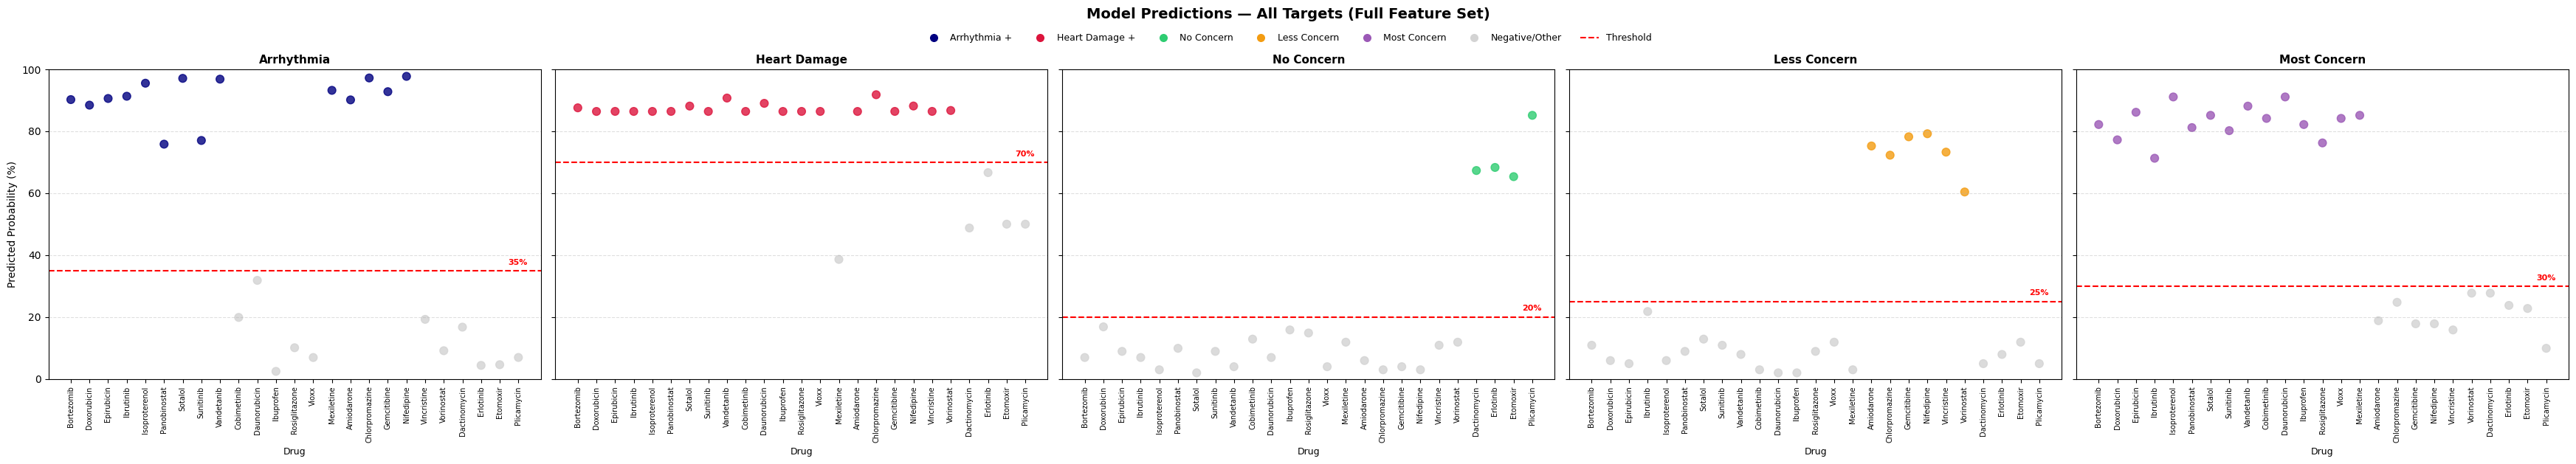


COMPUTED THRESHOLDS
  Arrhythmia: 35.0%
  Heart Damage: 70.0%
  No Concern: 20.0%
  Less Concern: 25.0%
  Most Concern: 30.0%

✓ All 5 prediction scatter plots generated in one row.


In [18]:
# Prediction Scatter Plots — All 5 Models in One Row (Arrhythmia First)
print("="*80)
print("PREDICTION SCATTER PLOTS — ALL MODELS (5 SUBPLOTS)")
print("="*80)

import numpy as np
import matplotlib.pyplot as plt

# Get predictions for all drugs
full_preds_hd = model_heart_damage.predict_proba(features_df)[:, 1] * 100
full_preds_arr = model_arrhythmia.predict_proba(features_df)[:, 1] * 100
full_preds_concern = model_concern_rf.predict_proba(features_df) * 100  # Shape: (n_drugs, 3)

drugs = df_raw['Drug']
positions = np.arange(len(drugs))

# Dynamic thresholds: set slightly above the highest negative prediction per target
margin_pp = 2.0  # wiggle room in percentage points

# ========================================
# Create 5 subplots in one horizontal row
# ========================================
fig, axes = plt.subplots(1, 5, figsize=(35, 6), sharey=True)

thresholds = {}
concern_thresholds = {}

# Get actual Concern labels for later
concern_actual = df_raw['Concern'].astype(str).str.strip().str.lower()
concern_map = {'no': 0, 'less': 1, 'most': 2}
concern_numeric = concern_actual.map(concern_map)

# Colors for Concern classes
class_colors = ['#2ecc71', '#f39c12', '#9b59b6']  # Green, Orange, Purple
class_names = ['No Concern', 'Less Concern', 'Most Concern']

# ========================================
# Plot 1: Arrhythmia
# ========================================
ax = axes[0]
preds = full_preds_arr
label = 'Arrhythmia'
color = 'navy'

status = df_raw['Arrhythmia'].astype(bool)
point_colors = status.map({True: color, False: 'lightgray'})
ax.scatter(positions, preds, c=point_colors, alpha=0.8, s=60)
ax.set_xticks(positions)
ax.set_xticklabels(drugs, rotation=90, fontsize=7)
ax.set_title(f'{label}', fontsize=11, fontweight='bold')
ax.set_xlabel('Drug', fontsize=9)
ax.grid(axis='y', linestyle='--', alpha=0.4)
ax.set_ylabel('Predicted Probability (%)', fontsize=10)
ax.set_ylim(0, 100)

# Compute threshold
neg_mask = ~status.values
if neg_mask.any():
    thr = float(np.max(preds[neg_mask])) + margin_pp
else:
    thr = float(np.percentile(preds, 50)) + margin_pp
thr = float(np.clip(thr, 0, 100))
thr = float(5 * np.ceil(thr / 5.0))
thresholds[label] = thr

# Add threshold line
ax.axhline(thr, color='red', linestyle='--', linewidth=1.5)
ax.text(len(drugs) - 0.5, thr + 1.5, f'{thr:.0f}%', color='red',
        fontsize=8, va='bottom', ha='right', fontweight='bold')

# ========================================
# Plot 2: Heart Damage
# ========================================
ax = axes[1]
preds = full_preds_hd
label = 'Heart Damage'
color = 'crimson'

status = df_raw['heart_damage'].astype(bool)
point_colors = status.map({True: color, False: 'lightgray'})
ax.scatter(positions, preds, c=point_colors, alpha=0.8, s=60)
ax.set_xticks(positions)
ax.set_xticklabels(drugs, rotation=90, fontsize=7)
ax.set_title(f'{label}', fontsize=11, fontweight='bold')
ax.set_xlabel('Drug', fontsize=9)
ax.grid(axis='y', linestyle='--', alpha=0.4)
ax.set_ylim(0, 100)

# Compute threshold
neg_mask = ~status.values
if neg_mask.any():
    thr = float(np.max(preds[neg_mask])) + margin_pp
else:
    thr = float(np.percentile(preds, 50)) + margin_pp
thr = float(np.clip(thr, 0, 100))
thr = float(5 * np.ceil(thr / 5.0))
thresholds[label] = thr

# Add threshold line
ax.axhline(thr, color='red', linestyle='--', linewidth=1.5)
ax.text(len(drugs) - 0.5, thr + 1.5, f'{thr:.0f}%', color='red',
        fontsize=8, va='bottom', ha='right', fontweight='bold')

# ========================================
# Plots 3-5: Concern (3 classes)
# ========================================
for idx, (class_name, class_color) in enumerate(zip(class_names, class_colors)):
    ax = axes[2 + idx]  # Plots 3, 4, 5
    preds = full_preds_concern[:, idx]
    
    # Color points: highlight if actual class matches, else gray
    point_colors = []
    for i, actual_class in enumerate(concern_numeric):
        if actual_class == idx:
            point_colors.append(class_color)
        else:
            point_colors.append('lightgray')
    
    ax.scatter(positions, preds, c=point_colors, alpha=0.8, s=60)
    ax.set_xticks(positions)
    ax.set_xticklabels(drugs, rotation=90, fontsize=7)
    ax.set_title(f'{class_name}', fontsize=11, fontweight='bold')
    ax.set_xlabel('Drug', fontsize=9)
    ax.grid(axis='y', linestyle='--', alpha=0.4)
    ax.set_ylim(0, 100)
    
    # Compute threshold: highest prediction for non-class samples + margin
    neg_mask = (concern_numeric != idx).values
    if neg_mask.any():
        thr = float(np.max(preds[neg_mask])) + margin_pp
    else:
        thr = float(np.percentile(preds, 50)) + margin_pp
    thr = float(np.clip(thr, 0, 100))
    thr = float(5 * np.ceil(thr / 5.0))
    concern_thresholds[class_name] = thr
    
    # Add threshold line
    ax.axhline(thr, color='red', linestyle='--', linewidth=1.5)
    ax.text(len(drugs) - 0.5, thr + 1.5, f'{thr:.0f}%', color='red',
            fontsize=8, va='bottom', ha='right', fontweight='bold')

# ========================================
# Unified legend at top
# ========================================
legend_handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='navy', 
               label='Arrhythmia +', markersize=9),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='crimson', 
               label='Heart Damage +', markersize=9),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=class_colors[0], 
               label='No Concern', markersize=9),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=class_colors[1], 
               label='Less Concern', markersize=9),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=class_colors[2], 
               label='Most Concern', markersize=9),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='lightgray', 
               label='Negative/Other', markersize=9),
    plt.Line2D([0], [0], color='red', linestyle='--', linewidth=1.5, label='Threshold')
]

fig.legend(handles=legend_handles, loc='upper center', ncol=7, 
           bbox_to_anchor=(0.5, 1.0), fontsize=9, frameon=False)

fig.suptitle('Model Predictions — All Targets (Full Feature Set)', 
             fontsize=14, fontweight='bold', y=1.04)
plt.tight_layout()
plt.subplots_adjust(top=0.90)
plt.show()

# ========================================
# Print computed thresholds
# ========================================
print("\n" + "="*80)
print("COMPUTED THRESHOLDS")
print("="*80)
print(f"  Arrhythmia: {thresholds.get('Arrhythmia', 0):.1f}%")
print(f"  Heart Damage: {thresholds.get('Heart Damage', 0):.1f}%")
for class_name, thr in concern_thresholds.items():
    print(f"  {class_name}: {thr:.1f}%")

print("\n✓ All 5 prediction scatter plots generated in one row.")

## Step 12: Compare Model Performance

Compare the performance of all three models side-by-side.


MODEL PERFORMANCE BAR PLOTS


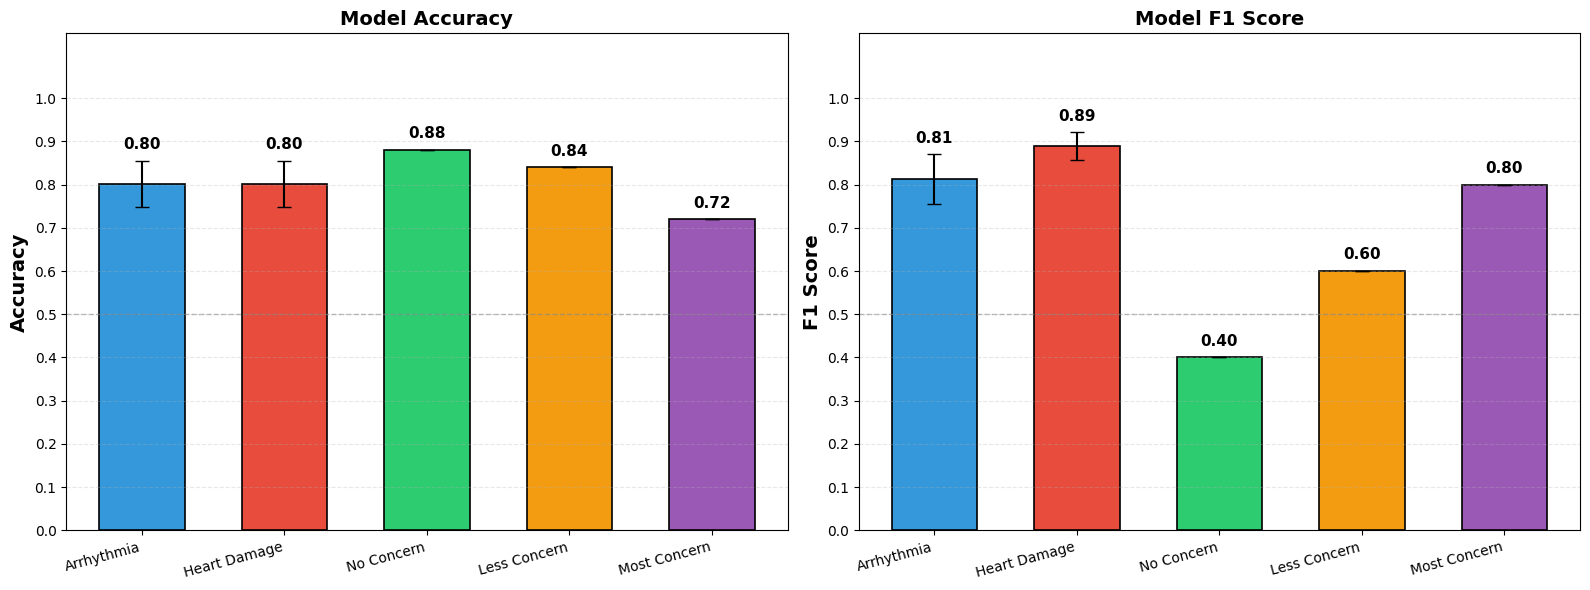


PERFORMANCE SUMMARY


,Model,Accuracy,F1 Score
0,Arrhythmia,0.80 ± 0.05,0.81 ± 0.06
1,Heart Damage,0.80 ± 0.05,0.89 ± 0.03
2,No Concern,0.88,0.40
3,Less Concern,0.84,0.60
4,Most Concern,0.72,0.80



✓ Model performance bar plots generated.


In [26]:
# Model Performance Bar Plots — Accuracy and F1 Score (All Models + Concern Per-Class)
print("="*80)
print("MODEL PERFORMANCE BAR PLOTS")
print("="*80)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score as sk_f1_score, accuracy_score
from sklearn.model_selection import cross_val_predict, StratifiedKFold

# ========================================
# Compute per-class metrics for Concern
# ========================================
cv_concern_metric = StratifiedKFold(n_splits=3, shuffle=True, random_state=122)
concern_pred = cross_val_predict(model_concern_rf, features_df, concern, cv=cv_concern_metric)

# Per-class F1 scores for Concern (labels: 0=no, 1=less, 2=most)
f1_per_class = sk_f1_score(concern, concern_pred, average=None, labels=[0, 1, 2])

# Per-class accuracy for Concern (compute for each class as binary)
accuracy_per_class = []
for class_idx in [0, 1, 2]:
    y_true_binary = (concern == class_idx).astype(int)
    y_pred_binary = (concern_pred == class_idx).astype(int)
    accuracy_per_class.append(accuracy_score(y_true_binary, y_pred_binary))

# ========================================
# Collect all metrics
# ========================================
models = ['Arrhythmia', 'Heart Damage', 'No Concern', 'Less Concern', 'Most Concern']
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6']  # Blue, Red, Green, Orange, Purple

# Accuracy values
accuracy_means = [
    results_arrhythmia['accuracy_mean'],
    results_heart_damage['accuracy_mean'],
    accuracy_per_class[0],
    accuracy_per_class[1],
    accuracy_per_class[2]
]
accuracy_stds = [
    results_arrhythmia['accuracy_std'],
    results_heart_damage['accuracy_std'],
    0,  # No std for per-class (single CV run)
    0,
    0
]

# F1 Score values
f1_means = [
    results_arrhythmia['f1_mean'],
    results_heart_damage['f1_mean'],
    f1_per_class[0],
    f1_per_class[1],
    f1_per_class[2]
]
f1_stds = [
    results_arrhythmia['f1_std'],
    results_heart_damage['f1_std'],
    0,  # No std for per-class
    0,
    0
]

# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

x = np.arange(len(models))
bar_width = 0.6

# ========================================
# Plot 1: Accuracy
# ========================================
ax1 = axes[0]
bars1 = ax1.bar(x, accuracy_means, bar_width, yerr=accuracy_stds, 
                color=colors, edgecolor='black', linewidth=1.2,
                capsize=5, error_kw={'linewidth': 1.5})

# Add value labels on bars
for i, (bar, val, std) in enumerate(zip(bars1, accuracy_means, accuracy_stds)):
    y_pos = bar.get_height() + std + 0.02 if std > 0 else bar.get_height() + 0.02
    ax1.text(bar.get_x() + bar.get_width()/2, y_pos,
             f'{val:.2f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

ax1.set_ylabel('Accuracy', fontsize=14, fontweight='bold')
ax1.set_title('Model Accuracy', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(models, fontsize=10, rotation=15, ha='right')
ax1.set_ylim(0, 1.15)
ax1.set_yticks(np.arange(0, 1.1, 0.1))
ax1.axhline(y=0.5, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax1.grid(axis='y', linestyle='--', alpha=0.3)

# ========================================
# Plot 2: F1 Score
# ========================================
ax2 = axes[1]
bars2 = ax2.bar(x, f1_means, bar_width, yerr=f1_stds,
                color=colors, edgecolor='black', linewidth=1.2,
                capsize=5, error_kw={'linewidth': 1.5})

# Add value labels on bars
for i, (bar, val, std) in enumerate(zip(bars2, f1_means, f1_stds)):
    y_pos = bar.get_height() + std + 0.02 if std > 0 else bar.get_height() + 0.02
    ax2.text(bar.get_x() + bar.get_width()/2, y_pos,
             f'{val:.2f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

ax2.set_ylabel('F1 Score', fontsize=14, fontweight='bold')
ax2.set_title('Model F1 Score', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(models, fontsize=10, rotation=15, ha='right')
ax2.set_ylim(0, 1.15)
ax2.set_yticks(np.arange(0, 1.1, 0.1))
ax2.axhline(y=0.5, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax2.grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

# ========================================
# Print Summary Table
# ========================================
print("\n" + "="*80)
print("PERFORMANCE SUMMARY")
print("="*80)
summary_df = pd.DataFrame({
    'Model': models,
    'Accuracy': [f'{m:.2f}' + (f' ± {s:.2f}' if s > 0 else '') for m, s in zip(accuracy_means, accuracy_stds)],
    'F1 Score': [f'{m:.2f}' + (f' ± {s:.2f}' if s > 0 else '') for m, s in zip(f1_means, f1_stds)]
})
display(summary_df)

print("\n✓ Model performance bar plots generated.")


ROC CURVE PLOTS — All Models in One Row

1. Computing ROC curves for Arrhythmia (XGBoost), per fold...
2. Computing ROC curves for Heart Damage (SVM-RBF), per fold...


c:\Users\NoahB\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:199: UserWarning: [17:40:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\NoahB\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:199: UserWarning: [17:40:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\NoahB\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:199: UserWarning: [17:40:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


3. Computing ROC curves for Concern (Random Forest, OvR), per fold...


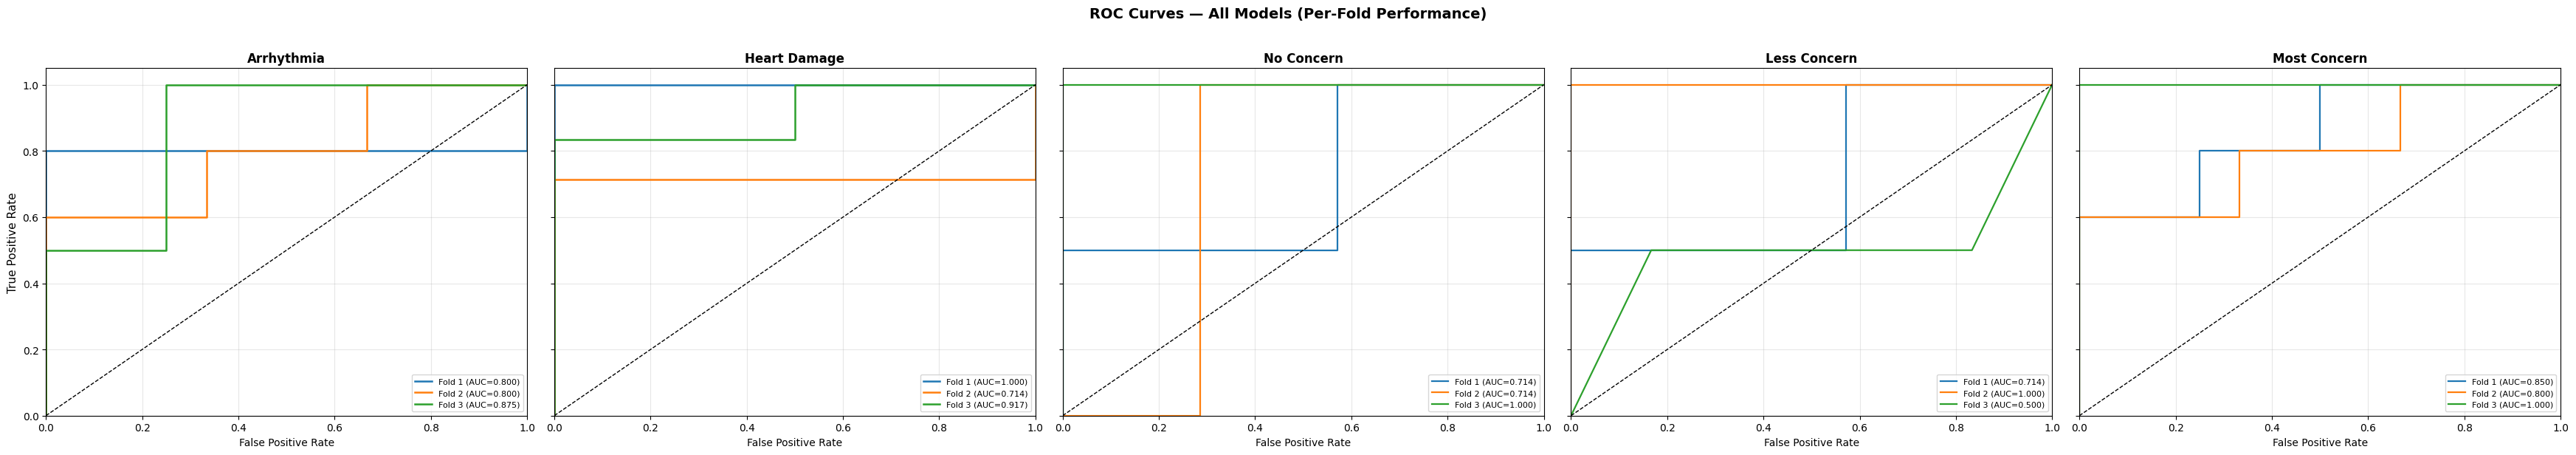


✓ ROC curves generated: 5 subplots in one row (Arrhythmia, Heart Damage, Concern×3).


In [19]:
# ROC CURVE PLOTS — All 5 in One Row (Arrhythmia, Heart Damage, Concern×3)
print("\n" + "="*80)
print("ROC CURVE PLOTS — All Models in One Row")
print("="*80)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# ========================================
# Create 5 subplots in one horizontal row
# ========================================
fig, axes = plt.subplots(1, 5, figsize=(35, 6), sharex=True, sharey=True)

# ========================================
# Plot 1: Arrhythmia (Binary, XGBoost)
# ========================================
print("\n1. Computing ROC curves for Arrhythmia (XGBoost), per fold...")
ax = axes[0]

n_folds = 3
cv_arr = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

if 'XGBOOST_AVAILABLE' in globals() and XGBOOST_AVAILABLE:
    import xgboost as xgb

for fold_idx, (train_idx, test_idx) in enumerate(cv_arr.split(features_df, arrhythmia), start=1):
    X_train, X_test = features_df.iloc[train_idx], features_df.iloc[test_idx]
    if hasattr(arrhythmia, 'iloc'):
        y_train, y_test = arrhythmia.iloc[train_idx], arrhythmia.iloc[test_idx]
    else:
        y_train, y_test = arrhythmia[train_idx], arrhythmia[test_idx]

    if 'XGBOOST_AVAILABLE' in globals() and XGBOOST_AVAILABLE:
        xgb_fold = xgb.XGBClassifier(
            n_estimators=150,
            max_depth=4,
            learning_rate=0.08,
            subsample=0.9,
            objective='binary:logistic',
            eval_metric='logloss',
            random_state=42,
            n_jobs=-1,
            use_label_encoder=False
        )
        pipeline_fold = Pipeline([
            ('scaler', StandardScaler()),
            ('xgb', xgb_fold)
        ])
    else:
        pipeline_fold = model_arrhythmia

    pipeline_fold.fit(X_train, y_train)
    y_pred_proba = pipeline_fold.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    fold_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, lw=1.8, label=f"Fold {fold_idx} (AUC={fold_auc:.3f})")

ax.plot([0, 1], [0, 1], 'k--', lw=1)
ax.set_ylabel('True Positive Rate', fontsize=11)
ax.set_xlabel('False Positive Rate', fontsize=10)
ax.set_title('Arrhythmia', fontsize=12, fontweight='bold')
ax.legend(loc='lower right', fontsize=8)
ax.grid(alpha=0.3)

# ========================================
# Plot 2: Heart Damage (Binary, SVM RBF)
# ========================================
print("2. Computing ROC curves for Heart Damage (SVM-RBF), per fold...")
ax = axes[1]

cv_hd = StratifiedKFold(n_splits=3, shuffle=True, random_state=21)

for fold_idx, (train_idx, test_idx) in enumerate(cv_hd.split(features_df, heart_damage), start=1):
    X_train, X_test = features_df.iloc[train_idx], features_df.iloc[test_idx]
    if hasattr(heart_damage, 'iloc'):
        y_train, y_test = heart_damage.iloc[train_idx], heart_damage.iloc[test_idx]
    else:
        y_train, y_test = heart_damage[train_idx], heart_damage[test_idx]

    svm_fold = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=40)
    pipeline_fold = Pipeline([
        ('scaler', StandardScaler()),
        ('svm', svm_fold)
    ])
    pipeline_fold.fit(X_train, y_train)

    y_scores = pipeline_fold.decision_function(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    fold_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, lw=1.8, label=f"Fold {fold_idx} (AUC={fold_auc:.3f})")

ax.plot([0, 1], [0, 1], 'k--', lw=1)
ax.set_xlabel('False Positive Rate', fontsize=10)
ax.set_title('Heart Damage', fontsize=12, fontweight='bold')
ax.legend(loc='lower right', fontsize=8)
ax.grid(alpha=0.3)

# ========================================
# Plots 3-5: Concern (Multiclass, 3 subplots)
# ========================================
print("3. Computing ROC curves for Concern (Random Forest, OvR), per fold...")

classes_concern = np.unique(concern)
n_classes = len(classes_concern)
y_bin_concern = label_binarize(concern, classes=classes_concern)

# Consistent naming: map numeric class values to standard names
class_name_map = {
    0: 'No Concern',
    1: 'Less Concern',
    2: 'Most Concern'
}

cv_concern = StratifiedKFold(n_splits=3, shuffle=True, random_state=122)

for j, class_val in enumerate(classes_concern):
    ax = axes[2 + j]  # Plots 3, 4, 5
    
    for fold_idx, (train_idx, test_idx) in enumerate(cv_concern.split(features_df, concern), start=1):
        X_train, X_test = features_df.iloc[train_idx], features_df.iloc[test_idx]
        if hasattr(concern, 'iloc'):
            concern_train = concern.iloc[train_idx]
        else:
            concern_train = concern[train_idx]

        model_concern_rf.fit(X_train, concern_train)
        y_test_bin = y_bin_concern[test_idx, j]
        y_pred_proba = model_concern_rf.predict_proba(X_test)[:, j]

        fpr, tpr, _ = roc_curve(y_test_bin, y_pred_proba)
        fold_auc = auc(fpr, tpr)
        ax.plot(fpr, tpr, lw=1.6, label=f"Fold {fold_idx} (AUC={fold_auc:.3f})")

    ax.plot([0, 1], [0, 1], 'k--', lw=1)
    ax.grid(alpha=0.3)
    
    # Use consistent class naming
    label_name = class_name_map.get(class_val, f"Class {class_val}")
    ax.set_title(label_name, fontsize=12, fontweight='bold')
    ax.set_xlabel('False Positive Rate', fontsize=10)
    ax.legend(loc='lower right', fontsize=8)

# ========================================
# Finalize figure
# ========================================
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])

fig.suptitle('ROC Curves — All Models (Per-Fold Performance)', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n✓ ROC curves generated: 5 subplots in one row (Arrhythmia, Heart Damage, Concern×3).")

Need to define the threshold for the confusion matricies before running them.

CONFUSION MATRICES FOR ALL MODELS (Aggregated from All 3 Folds)
Arrhythmia threshold: 35.0% | Total samples: 25
Heart Damage threshold: 70.0% | Total samples: 25


c:\Users\NoahB\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:199: UserWarning: [17:44:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\NoahB\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:199: UserWarning: [17:44:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\NoahB\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:199: UserWarning: [17:44:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Concern: argmax prediction | Total samples: 25

1. Arrhythmia (XGBoost)
2. Heart Damage (Gaussian Kernel SVM)
3. Concern (Random Forest, Multiclass)


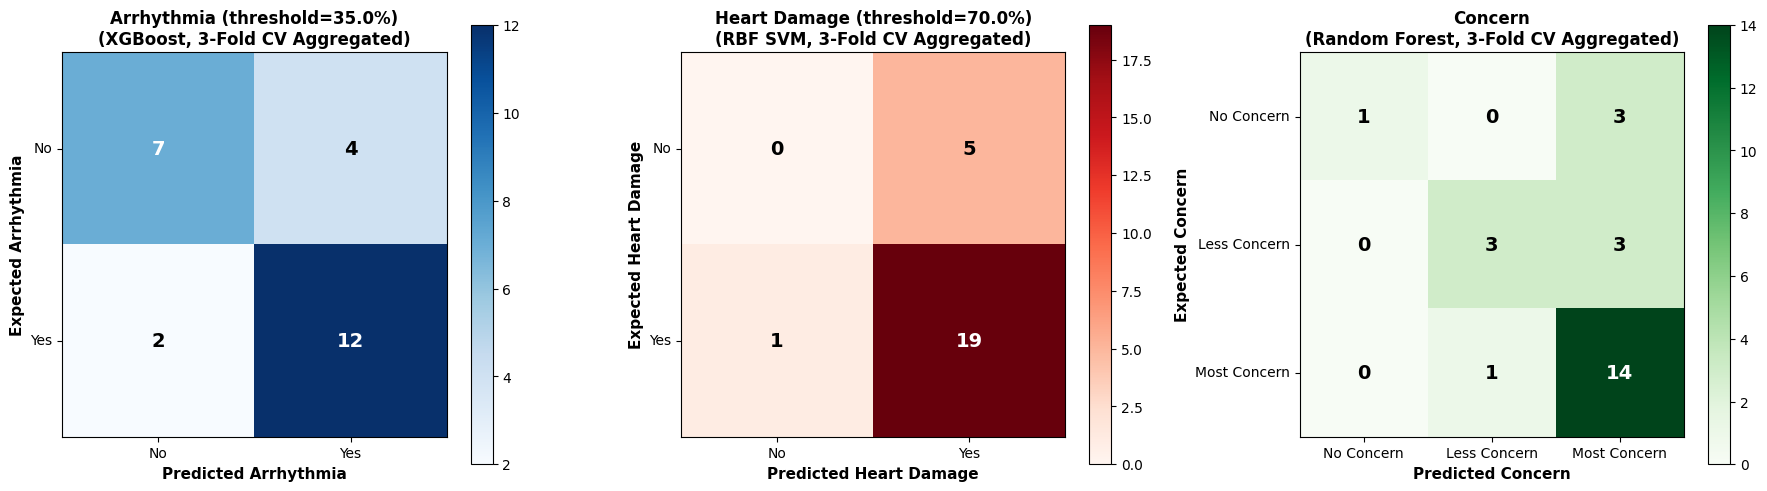


CLASSIFICATION REPORTS (Aggregated from All 3 Folds)

--- Arrhythmia ---
Total samples: 25
               precision    recall  f1-score   support

No Arrhythmia       0.78      0.64      0.70        11
   Arrhythmia       0.75      0.86      0.80        14

     accuracy                           0.76        25
    macro avg       0.76      0.75      0.75        25
 weighted avg       0.76      0.76      0.76        25


--- Heart Damage ---
Total samples: 25
              precision    recall  f1-score   support

   No Damage       0.00      0.00      0.00         5
      Damage       0.79      0.95      0.86        20

    accuracy                           0.76        25
   macro avg       0.40      0.47      0.43        25
weighted avg       0.63      0.76      0.69        25


--- Concern ---
Total samples: 25
              precision    recall  f1-score   support

  No Concern       1.00      0.25      0.40         4
Less Concern       0.75      0.50      0.60         6
Most Conce

c:\Users\NoahB\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:199: UserWarning: [17:44:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [20]:
# Confusion Matrices — Arrhythmia, Heart Damage, and Concern (Aggregated from All 3 Folds)
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold
import numpy as np
import matplotlib.pyplot as plt

print("="*80)
print("CONFUSION MATRICES FOR ALL MODELS (Aggregated from All 3 Folds)")
print("="*80)

# ========================================
# Arrhythmia: Aggregate predictions from all 3 folds
# ========================================
arr_threshold = thresholds.get('Arrhythmia', 35.0) / 100.0
cv_arr = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

arr_y_true_all = []
arr_y_pred_all = []

for fold_idx, (train_idx, test_idx) in enumerate(cv_arr.split(features_df, arrhythmia), start=1):
    X_train, X_test = features_df.iloc[train_idx], features_df.iloc[test_idx]
    y_train = arrhythmia[train_idx] if isinstance(arrhythmia, np.ndarray) else arrhythmia.iloc[train_idx]
    y_test = arrhythmia[test_idx] if isinstance(arrhythmia, np.ndarray) else arrhythmia.iloc[test_idx]
    
    # Retrain model on this fold's training data
    model_arrhythmia.fit(X_train, y_train)
    y_proba = model_arrhythmia.predict_proba(X_test)[:, 1]
    y_pred = (y_proba >= arr_threshold).astype(int)
    
    arr_y_true_all.extend(y_test)
    arr_y_pred_all.extend(y_pred)

arr_y_true_all = np.array(arr_y_true_all)
arr_y_pred_all = np.array(arr_y_pred_all)
print(f"Arrhythmia threshold: {arr_threshold*100:.1f}% | Total samples: {len(arr_y_true_all)}")

# ========================================
# Heart Damage: Aggregate predictions from all 3 folds
# ========================================
hd_threshold = thresholds.get('Heart Damage', 70.0) / 100.0
cv_hd = StratifiedKFold(n_splits=3, shuffle=True, random_state=21)

hd_y_true_all = []
hd_y_pred_all = []

for fold_idx, (train_idx, test_idx) in enumerate(cv_hd.split(features_df, heart_damage), start=1):
    X_train, X_test = features_df.iloc[train_idx], features_df.iloc[test_idx]
    y_train = heart_damage[train_idx] if isinstance(heart_damage, np.ndarray) else heart_damage.iloc[train_idx]
    y_test = heart_damage[test_idx] if isinstance(heart_damage, np.ndarray) else heart_damage.iloc[test_idx]
    
    # Retrain model on this fold's training data
    model_heart_damage.fit(X_train, y_train)
    y_proba = model_heart_damage.predict_proba(X_test)[:, 1]
    y_pred = (y_proba >= hd_threshold).astype(int)
    
    hd_y_true_all.extend(y_test)
    hd_y_pred_all.extend(y_pred)

hd_y_true_all = np.array(hd_y_true_all)
hd_y_pred_all = np.array(hd_y_pred_all)
print(f"Heart Damage threshold: {hd_threshold*100:.1f}% | Total samples: {len(hd_y_true_all)}")

# ========================================
# Concern: Aggregate predictions from all 3 folds
# ========================================
cv_concern = StratifiedKFold(n_splits=3, shuffle=True, random_state=122)

concern_y_true_all = []
concern_y_pred_all = []

for fold_idx, (train_idx, test_idx) in enumerate(cv_concern.split(features_df, concern), start=1):
    X_train, X_test = features_df.iloc[train_idx], features_df.iloc[test_idx]
    y_train = concern[train_idx] if isinstance(concern, np.ndarray) else concern.iloc[train_idx]
    y_test = concern[test_idx] if isinstance(concern, np.ndarray) else concern.iloc[test_idx]
    
    # Retrain model on this fold's training data
    model_concern_rf.fit(X_train, y_train)
    y_pred = model_concern_rf.predict(X_test)
    
    concern_y_true_all.extend(y_test)
    concern_y_pred_all.extend(y_pred)

concern_y_true_all = np.array(concern_y_true_all)
concern_y_pred_all = np.array(concern_y_pred_all)
print(f"Concern: argmax prediction | Total samples: {len(concern_y_true_all)}")

# ========================================
# Plot Confusion Matrices (Aggregated)
# ========================================
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# ========================================
# 1. Arrhythmia Confusion Matrix
# ========================================
print("\n1. Arrhythmia (XGBoost)")
cm_arr = confusion_matrix(arr_y_true_all, arr_y_pred_all)
ax1 = axes[0]
im1 = ax1.imshow(cm_arr, interpolation='nearest', cmap='Blues')
ax1.figure.colorbar(im1, ax=ax1)
ax1.set(xticks=[0, 1], yticks=[0, 1],
        xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
ax1.set_yticklabels(['No', 'Yes'], rotation=0, va='center')
ax1.set_xlabel('Predicted Arrhythmia', fontsize=11, fontweight='bold')
ax1.set_ylabel('Expected Arrhythmia', fontsize=11, fontweight='bold')
ax1.set_title(f'Arrhythmia (threshold={arr_threshold*100:.1f}%)\n(XGBoost, 3-Fold CV Aggregated)', fontsize=12, fontweight='bold')

thresh1 = cm_arr.max() / 2.
for i in range(cm_arr.shape[0]):
    for j in range(cm_arr.shape[1]):
        ax1.text(j, i, format(cm_arr[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm_arr[i, j] > thresh1 else "black",
                 fontsize=14, fontweight='bold')

# ========================================
# 2. Heart Damage Confusion Matrix
# ========================================
print("2. Heart Damage (Gaussian Kernel SVM)")
cm_hd = confusion_matrix(hd_y_true_all, hd_y_pred_all)
ax2 = axes[1]
im2 = ax2.imshow(cm_hd, interpolation='nearest', cmap='Reds')
ax2.figure.colorbar(im2, ax=ax2)
ax2.set(xticks=[0, 1], yticks=[0, 1],
        xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
ax2.set_yticklabels(['No', 'Yes'], rotation=0, va='center')
ax2.set_xlabel('Predicted Heart Damage', fontsize=11, fontweight='bold')
ax2.set_ylabel('Expected Heart Damage', fontsize=11, fontweight='bold')
ax2.set_title(f'Heart Damage (threshold={hd_threshold*100:.1f}%)\n(RBF SVM, 3-Fold CV Aggregated)', fontsize=12, fontweight='bold')

thresh2 = cm_hd.max() / 2.
for i in range(cm_hd.shape[0]):
    for j in range(cm_hd.shape[1]):
        ax2.text(j, i, format(cm_hd[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm_hd[i, j] > thresh2 else "black",
                 fontsize=14, fontweight='bold')

# ========================================
# 3. Concern Confusion Matrix (Multiclass)
# ========================================
print("3. Concern (Random Forest, Multiclass)")
cm_concern = confusion_matrix(concern_y_true_all, concern_y_pred_all)
ax3 = axes[2]
im3 = ax3.imshow(cm_concern, interpolation='nearest', cmap='Greens')
ax3.figure.colorbar(im3, ax=ax3)
ax3.set(xticks=[0, 1, 2], yticks=[0, 1, 2],
        xticklabels=['No Concern', 'Less Concern', 'Most Concern'], 
        yticklabels=['No Concern', 'Less Concern', 'Most Concern'])
ax3.set_yticklabels(['No Concern', 'Less Concern', 'Most Concern'], rotation=0, va='center')
ax3.set_xlabel('Predicted Concern', fontsize=11, fontweight='bold')
ax3.set_ylabel('Expected Concern', fontsize=11, fontweight='bold')
ax3.set_title('Concern\n(Random Forest, 3-Fold CV Aggregated)', fontsize=12, fontweight='bold')

thresh3 = cm_concern.max() / 2.
for i in range(cm_concern.shape[0]):
    for j in range(cm_concern.shape[1]):
        ax3.text(j, i, format(cm_concern[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm_concern[i, j] > thresh3 else "black",
                 fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# ========================================
# Print Classification Reports
# ========================================
print("\n" + "="*80)
print("CLASSIFICATION REPORTS (Aggregated from All 3 Folds)")
print("="*80)

print("\n--- Arrhythmia ---")
print(f"Total samples: {len(arr_y_true_all)}")
print(classification_report(arr_y_true_all, arr_y_pred_all, 
                            target_names=['No Arrhythmia', 'Arrhythmia'], zero_division=0))

print("\n--- Heart Damage ---")
print(f"Total samples: {len(hd_y_true_all)}")
print(classification_report(hd_y_true_all, hd_y_pred_all, 
                            target_names=['No Damage', 'Damage'], zero_division=0))

print("\n--- Concern ---")
print(f"Total samples: {len(concern_y_true_all)}")
print(classification_report(concern_y_true_all, concern_y_pred_all, 
                            target_names=['No Concern', 'Less Concern', 'Most Concern'], zero_division=0))

print("\n✓ Confusion matrices for all models generated (aggregated from all 3 folds).")

# Retrain final models on all data (restore state)
print("\nRetraining final models on all data...")
model_arrhythmia.fit(features_df, arrhythmia)
model_heart_damage.fit(features_df, heart_damage)
model_concern_rf.fit(features_df, concern)
print("✓ Models restored to full-data state.")

## Step 13: Feature Importance Summary

Compare which PK-PD elimination coefficients are most important for each target.


FEATURE IMPORTANCE/COEFFICIENT SUMMARY
Note: Different models provide different interpretability:
  - XGBoost (Arrhythmia): Feature importances
  - Gaussian Kernel (Heart Damage): Permutation importance
  - Random Forest (Concern): Feature importances

Top 10 Features for Arrhythmia (XGBoost Feature Importances):


,Feature,Importance
0,R0_Contractility,0.269799
6,k_elim_Contractility,0.104979
5,tau_Contractility,0.103587
4,m_Contractility,0.099338
7,R0_O2,0.094837
10,n_O2,0.074466
2,kappa_Contractility,0.050019
9,kappa_O2,0.047848
8,Emax_O2,0.046190
11,m_O2,0.041327



Top 10 Features for Heart Damage (Permutation Importance):


,Feature,Importance
2,kappa_Contractility,0.040
4,m_Contractility,0.036
7,R0_O2,0.032
3,n_Contractility,0.028
11,m_O2,0.028
13,k_elim_O2,0.028
10,n_O2,0.020
12,tau_O2,0.020
5,tau_Contractility,0.020
8,Emax_O2,0.020



Top 10 Features for Concern (Random Forest Feature Importances):


,Feature,Importance
10,n_O2,0.141106
0,R0_Contractility,0.108791
12,tau_O2,0.086828
9,kappa_O2,0.084372
1,Emax_Contractility,0.083495
5,tau_Contractility,0.081914
13,k_elim_O2,0.078191
6,k_elim_Contractility,0.077782
4,m_Contractility,0.064236
2,kappa_Contractility,0.052821



GENERATING CUMULATIVE FEATURE PLOTS (5 SUBPLOTS)


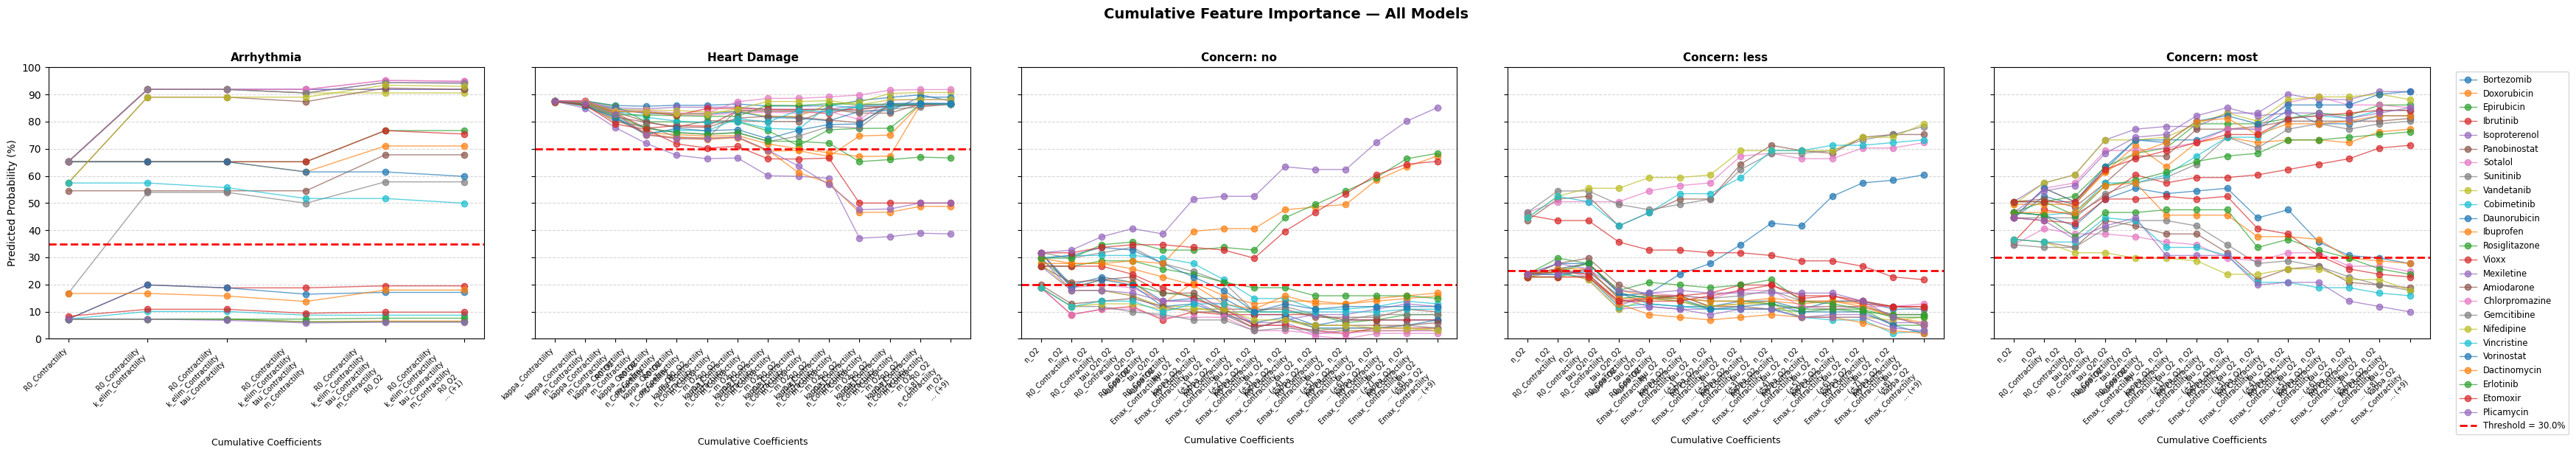


TOP FEATURES COMPARISON

Top 5 features by model:
Arrhythmia: tau_Contractility, k_elim_Contractility, R0_Contractility, m_Contractility, R0_O2
Heart Damage: n_Contractility, kappa_Contractility, m_O2, m_Contractility, R0_O2
Concern: n_O2, R0_Contractility, Emax_Contractility, kappa_O2, tau_O2

Features in top 5 for ALL models: 0

Features in top 5 for Arrhythmia + Heart Damage only: 2
  ['m_Contractility', 'R0_O2']

Features in top 5 for Arrhythmia + Concern only: 1
  ['R0_Contractility']

Features in top 5 for Heart Damage + Concern only: 0

✓ Feature importance summary with thresholds complete!


In [ ]:
# Cell 14: Feature Importance Summary with Threshold Lines
print("="*80)
print("FEATURE IMPORTANCE/COEFFICIENT SUMMARY")
print("="*80)
print("Note: Different models provide different interpretability:")
print("  - XGBoost (Arrhythmia): Feature importances")
print("  - Gaussian Kernel (Heart Damage): Permutation importance")
print("  - Random Forest (Concern): Feature importances")
print("="*80)

top_n = 10

print(f"\nTop {top_n} Features for Arrhythmia (XGBoost Feature Importances):")
display(results_arrhythmia['feature_importances'].head(top_n))

# Compute permutation importance for Heart Damage if not already done
if 'heart_damage_importances' not in globals():
    from sklearn.inspection import permutation_importance
    print("\nComputing permutation importance for Heart Damage (Gaussian Kernel)...")
    perm_importance = permutation_importance(
        model_heart_damage, 
        features_df, 
        heart_damage, 
        n_repeats=10,
        random_state=42,
        n_jobs=-1
    )
    heart_damage_importances = pd.DataFrame({
        'Feature': features_df.columns,
        'Importance': perm_importance.importances_mean
    }).sort_values('Importance', ascending=False)

print(f"\nTop {top_n} Features for Heart Damage (Permutation Importance):")
display(heart_damage_importances.head(top_n))

print(f"\nTop {top_n} Features for Concern (Random Forest Feature Importances):")
display(results_concern_rf['feature_importances'].head(top_n))

# ========================================
# CUMULATIVE FEATURE IMPORTANCE PLOTS WITH THRESHOLDS
# ONE LONG HORIZONTAL FIGURE (5 SUBPLOTS)
# ========================================
import matplotlib.pyplot as plt

# Get thresholds from earlier computation
arr_threshold = thresholds.get('Arrhythmia', 35.0)
hd_threshold = thresholds.get('Heart Damage', 70.0)

print("\n" + "="*80)
print("GENERATING CUMULATIVE FEATURE PLOTS (5 SUBPLOTS)")
print("="*80)

# ========================================
# Prepare data for all 5 plots
# ========================================

# 1. Arrhythmia
top_features_arr = results_arrhythmia['feature_importances'].head(6)['Feature'].tolist()
drug_preds_arr = []

for drug in df_raw['Drug']:
    drug_idx = df_raw.index[df_raw['Drug'] == drug][0]
    for rank in range(1, len(top_features_arr) + 1):
        single_vector = pd.DataFrame(0, index=[0], columns=features_df.columns)
        for past_feature in top_features_arr[:rank]:
            single_vector[past_feature] = features_df.loc[drug_idx, past_feature]
        prob = model_arrhythmia.predict_proba(single_vector)[:, 1][0]
        drug_preds_arr.append({
            'Drug': drug,
            'Rank': rank,
            'Arrhythmia (%)': prob * 100
        })

plot_df_arr = pd.DataFrame(drug_preds_arr)

# 2. Heart Damage
top_features_hd = heart_damage_importances['Feature'].tolist()
num_features_hd = len(top_features_hd)

drug_preds_hd = []
for drug in df_raw['Drug']:
    drug_idx = df_raw.index[df_raw['Drug'] == drug][0]
    for rank in range(1, num_features_hd + 1):
        single_vector = pd.DataFrame(0, index=[0], columns=features_df.columns)
        for past_feature in top_features_hd[:rank]:
            single_vector[past_feature] = features_df.loc[drug_idx, past_feature]
        prob = model_heart_damage.predict_proba(single_vector)[:, 1][0]
        drug_preds_hd.append({
            'Drug': drug,
            'Rank': rank,
            'Heart Damage (%)': prob * 100
        })

plot_df_hd = pd.DataFrame(drug_preds_hd)

# 3. Concern (all 3 classes)
top_features_concern = results_concern_rf['feature_importances']['Feature'].tolist()
num_features_concern = len(top_features_concern)

drug_preds_concern = []
for drug in df_raw['Drug']:
    drug_idx = df_raw.index[df_raw['Drug'] == drug][0]
    for rank in range(1, num_features_concern + 1):
        single_vector = pd.DataFrame(0, index=[0], columns=features_df.columns)
        for feature in top_features_concern[:rank]:
            single_vector[feature] = features_df.loc[drug_idx, feature]
        
        probs = model_concern_rf.predict_proba(single_vector)[0]
        drug_preds_concern.append({
            'Drug': drug,
            'Rank': rank,
            'Concern: no (%)': probs[0] * 100,
            'Concern: less (%)': probs[1] * 100,
            'Concern: most (%)': probs[2] * 100
        })

plot_df_concern = pd.DataFrame(drug_preds_concern)

# ========================================
# Create 5 subplots in one horizontal figure
# ========================================
fig, axes = plt.subplots(1, 5, figsize=(35, 6), sharey=True)

# Get concern thresholds
concern_thr_no = concern_thresholds.get('No Concern', 50.0)
concern_thr_less = concern_thresholds.get('Less Concern', 50.0)
concern_thr_most = concern_thresholds.get('Most Concern', 50.0)

# ========================================
# Plot 1: Arrhythmia
# ========================================
ax = axes[0]

def stacked_label_arr(rank):
    if rank <= 5:
        return "\n".join(top_features_arr[:rank])
    else:
        return "\n".join(top_features_arr[:5]) + f"\n... (+{rank-5})"

xtick_labels_arr = [stacked_label_arr(i) for i in range(1, len(top_features_arr) + 1)]

for drug in plot_df_arr['Drug'].unique():
    subset = plot_df_arr[plot_df_arr['Drug'] == drug]
    ax.plot(subset['Rank'], subset['Arrhythmia (%)'], marker='o', label=drug, alpha=0.7, linewidth=1)

ax.axhline(y=arr_threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold = {arr_threshold:.1f}%')
ax.set_xticks(range(1, len(top_features_arr) + 1))
ax.set_xticklabels(xtick_labels_arr, rotation=45, ha='right', fontsize=7)
ax.set_yticks(np.linspace(0, 100, 11))
ax.set_ylim(0, 100)
ax.set_xlabel('Cumulative Coefficients', fontsize=9)
ax.set_ylabel('Predicted Probability (%)', fontsize=10)
ax.set_title('Arrhythmia', fontsize=11, fontweight='bold')
ax.grid(axis='y', linestyle='--', alpha=0.5)

# ========================================
# Plot 2: Heart Damage
# ========================================
ax = axes[1]

def stacked_label_hd(rank):
    if rank <= 5:
        return "\n".join(top_features_hd[:rank])
    else:
        return "\n".join(top_features_hd[:5]) + f"\n... (+{rank-5})"

xtick_labels_hd = [stacked_label_hd(i) for i in range(1, num_features_hd + 1)]

for drug in plot_df_hd['Drug'].unique():
    subset = plot_df_hd[plot_df_hd['Drug'] == drug]
    ax.plot(subset['Rank'], subset['Heart Damage (%)'], marker='o', label=drug, alpha=0.7, linewidth=1)

ax.axhline(y=hd_threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold = {hd_threshold:.1f}%')
ax.set_xticks(range(1, num_features_hd + 1))
ax.set_xticklabels(xtick_labels_hd, rotation=45, ha='right', fontsize=7)
ax.set_yticks(np.linspace(0, 100, 11))
ax.set_ylim(0, 100)
ax.set_xlabel('Cumulative Coefficients', fontsize=9)
ax.set_title('Heart Damage', fontsize=11, fontweight='bold')
ax.grid(axis='y', linestyle='--', alpha=0.5)

# ========================================
# Plots 3-5: Concern (3 classes)
# ========================================
def stacked_label_concern(rank):
    if rank <= 5:
        return "\n".join(top_features_concern[:rank])
    else:
        return "\n".join(top_features_concern[:5]) + f"\n... (+{rank-5})"

xtick_labels_concern = [stacked_label_concern(i) for i in range(1, num_features_concern + 1)]

class_labels = ['Concern: No', 'Concern: less', 'Concern: most']
concern_thrs = [concern_thr_no, concern_thr_less, concern_thr_most]

for idx, (class_label, thr) in enumerate(zip(class_labels, concern_thrs)):
    ax = axes[2 + idx]  # Plots 3, 4, 5
    column_name = f'{class_label} (%)'
    
    for drug in plot_df_concern['Drug'].unique():
        subset = plot_df_concern[plot_df_concern['Drug'] == drug]
        ax.plot(subset['Rank'], subset[column_name], marker='o', label=drug, alpha=0.7, linewidth=1)
    
    ax.axhline(y=thr, color='red', linestyle='--', linewidth=2, label=f'Threshold = {thr:.1f}%')
    ax.set_xticks(range(1, num_features_concern + 1))
    ax.set_xticklabels(xtick_labels_concern, rotation=45, ha='right', fontsize=7)
    ax.set_yticks(np.linspace(0, 100, 11))
    ax.set_ylim(0, 100)
    ax.set_xlabel('Cumulative Coefficients', fontsize=9)
    ax.set_title(class_label, fontsize=11, fontweight='bold')
    ax.grid(axis='y', linestyle='--', alpha=0.5)

# ========================================
# Legend on rightmost subplot
# ========================================
axes[4].legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1, fontsize='small')

fig.suptitle('Cumulative Feature Importance — All Models', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# ========================================
# Top Features Comparison
# ========================================
print("\n" + "="*80)
print("TOP FEATURES COMPARISON")
print("="*80)

top_arr = set(results_arrhythmia['feature_importances'].head(5)['Feature'].values)
top_hd = set(heart_damage_importances.head(5)['Feature'].values)
top_con = set(results_concern_rf['feature_importances'].head(5)['Feature'].values)

print("\nTop 5 features by model:")
print(f"Arrhythmia: {', '.join(top_arr)}")
print(f"Heart Damage: {', '.join(top_hd)}")
print(f"Concern: {', '.join(top_con)}")

common_all = top_arr & top_hd & top_con
common_arr_hd = (top_arr & top_hd) - common_all
common_arr_con = (top_arr & top_con) - common_all
common_hd_con = (top_hd & top_con) - common_all

print(f"\nFeatures in top 5 for ALL models: {len(common_all)}")
if common_all:
    print(f"  {list(common_all)}")

print(f"\nFeatures in top 5 for Arrhythmia + Heart Damage only: {len(common_arr_hd)}")
if common_arr_hd:
    print(f"  {list(common_arr_hd)}")

print(f"\nFeatures in top 5 for Arrhythmia + Concern only: {len(common_arr_con)}")
if common_arr_con:
    print(f"  {list(common_arr_con)}")

print(f"\nFeatures in top 5 for Heart Damage + Concern only: {len(common_hd_con)}")
if common_hd_con:
    print(f"  {list(common_hd_con)}")

print("\n✓ Feature importance summary with thresholds complete!")

## SHAP Feature Importance - Arrhythmia + Heart Damage Model
SHAP (SHapley Additive exPlanations) provides a unified measure of feature importance by assigning each feature an importance value for a particular prediction.

SHAP ANALYSIS — ALL MODELS (5 Separate Figures)

1. Computing SHAP for Arrhythmia (XGBoost)...
2. Computing SHAP for Heart Damage (RBF SVM, KernelSHAP)...


100%|██████████| 25/25 [00:01<00:00, 16.39it/s]


3. Computing SHAP for Concern (Random Forest, 3 classes)...

PLOT 1: Arrhythmia (XGBoost)


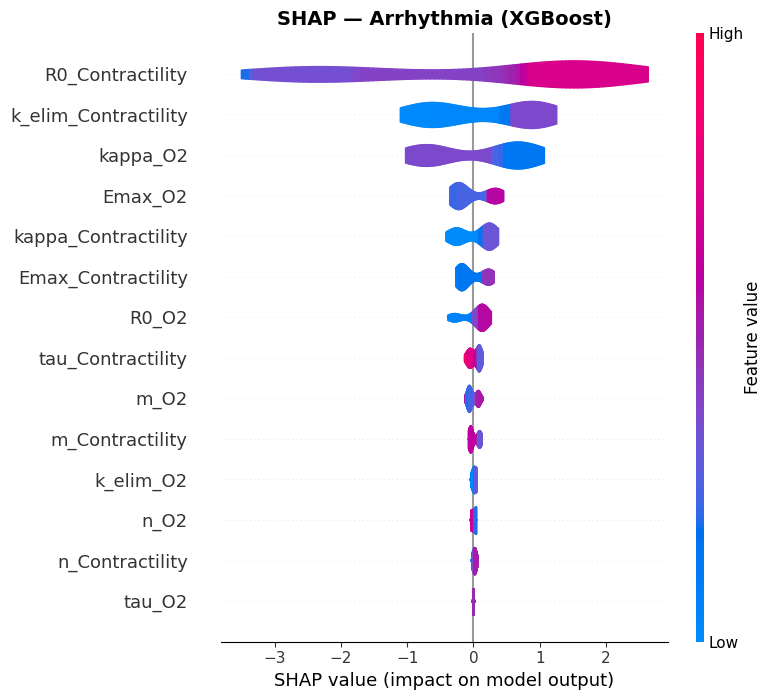


PLOT 2: Heart Damage (RBF SVM)


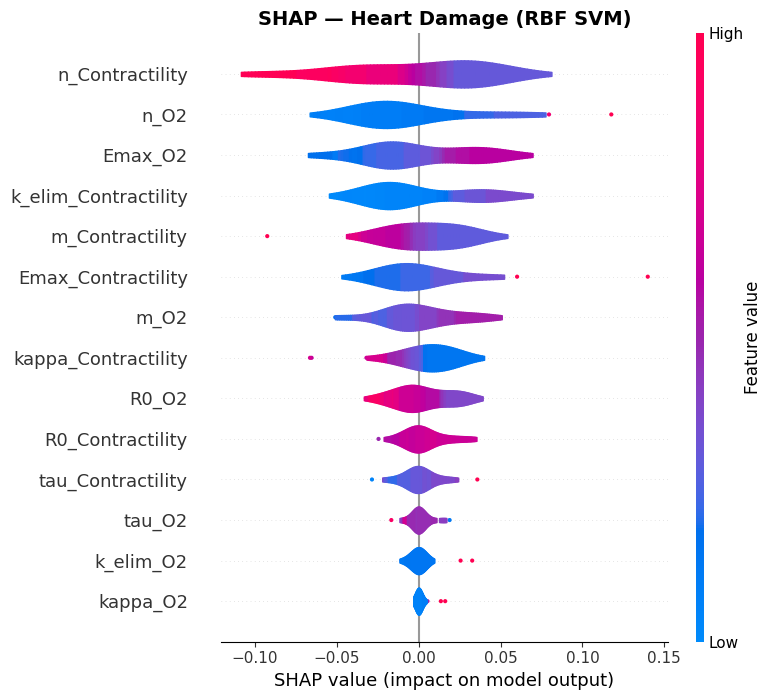


PLOT 3: No Concern (Random Forest)


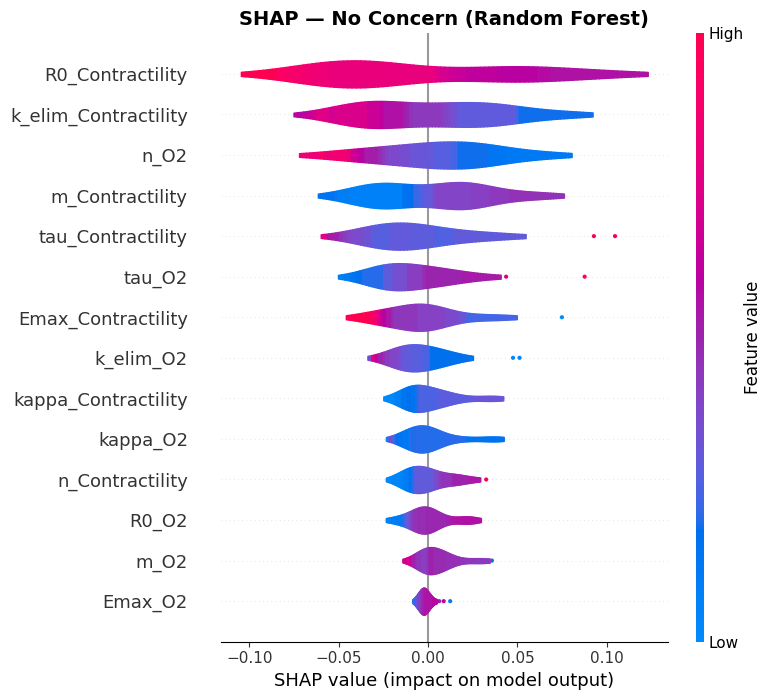


PLOT 4: Less Concern (Random Forest)


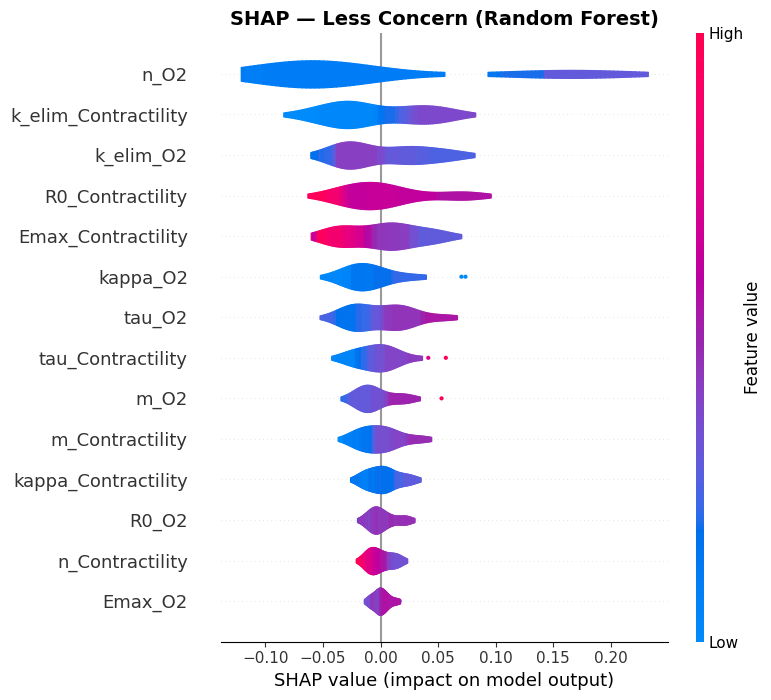


PLOT 5: Most Concern (Random Forest)


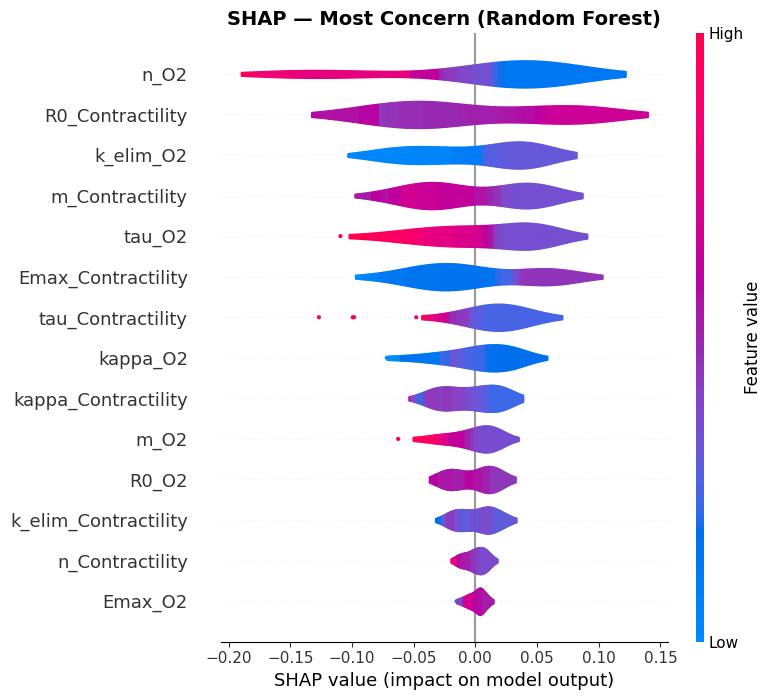


✓ SHAP analysis complete: 5 separate figures generated.


In [29]:
# SHAP Summary — 5 Separate Figures
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt

print("="*80)
print("SHAP ANALYSIS — ALL MODELS (5 Separate Figures)")
print("="*80)

# ===========================
# 1. Arrhythmia: XGBoost
# ===========================
print("\n1. Computing SHAP for Arrhythmia (XGBoost)...")
xgb_model = model_arrhythmia.named_steps['xgb']
scaler_arr = model_arrhythmia.named_steps['scaler']
X_scaled_arr = scaler_arr.transform(features_df)
X_scaled_arr_df = pd.DataFrame(X_scaled_arr, columns=features_df.columns, index=features_df.index)

explainer_arr = shap.TreeExplainer(xgb_model)
shap_values_arr = explainer_arr.shap_values(X_scaled_arr)

# ===========================
# 2. Heart Damage: RBF SVM (KernelSHAP)
# ===========================
print("2. Computing SHAP for Heart Damage (RBF SVM, KernelSHAP)...")
feature_names_hd = features_df.columns.tolist()

def predict_hd(X):
    X_df = pd.DataFrame(X, columns=feature_names_hd)
    return model_heart_damage.predict_proba(X_df)[:, 1]

try:
    background_hd = shap.kmeans(features_df, k=min(10, len(features_df)))
except Exception:
    background_hd = features_df.sample(min(10, len(features_df)), random_state=42).values

explainer_hd = shap.KernelExplainer(predict_hd, background_hd)
shap_values_hd = explainer_hd.shap_values(features_df.values, nsamples='auto')

# ===========================
# 3. Concern: Random Forest (3 Classes)
# ===========================
print("3. Computing SHAP for Concern (Random Forest, 3 classes)...")
rf_model = model_concern_rf.named_steps['rf']
scaler_concern = model_concern_rf.named_steps['scaler']
X_scaled_concern = scaler_concern.transform(features_df)
X_scaled_concern_df = pd.DataFrame(X_scaled_concern, columns=features_df.columns, index=features_df.index)

explainer_concern = shap.TreeExplainer(rf_model)
shap_values_concern_raw = explainer_concern.shap_values(X_scaled_concern)

if isinstance(shap_values_concern_raw, list):
    shap_values_concern = shap_values_concern_raw
else:
    n_classes = shap_values_concern_raw.shape[2] if len(shap_values_concern_raw.shape) == 3 else 3
    shap_values_concern = [shap_values_concern_raw[:, :, i] for i in range(n_classes)]

# ===========================
# Plot 1: Arrhythmia
# ===========================
print("\n" + "="*80)
print("PLOT 1: Arrhythmia (XGBoost)")
print("="*80)
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values_arr, X_scaled_arr_df, plot_type="violin", show=False)
plt.title('SHAP — Arrhythmia (XGBoost)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# ===========================
# Plot 2: Heart Damage
# ===========================
print("\n" + "="*80)
print("PLOT 2: Heart Damage (RBF SVM)")
print("="*80)
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values_hd, features_df, plot_type="violin", show=False)
plt.title('SHAP — Heart Damage (RBF SVM)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# ===========================
# Plot 3: No Concern
# ===========================
print("\n" + "="*80)
print("PLOT 3: No Concern (Random Forest)")
print("="*80)
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values_concern[0], X_scaled_concern_df, plot_type="violin", show=False)
plt.title('SHAP — No Concern (Random Forest)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# ===========================
# Plot 4: Less Concern
# ===========================
print("\n" + "="*80)
print("PLOT 4: Less Concern (Random Forest)")
print("="*80)
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values_concern[1], X_scaled_concern_df, plot_type="violin", show=False)
plt.title('SHAP — Less Concern (Random Forest)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# ===========================
# Plot 5: Most Concern
# ===========================
print("\n" + "="*80)
print("PLOT 5: Most Concern (Random Forest)")
print("="*80)
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values_concern[2], X_scaled_concern_df, plot_type="violin", show=False)
plt.title('SHAP — Most Concern (Random Forest)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n✓ SHAP analysis complete: 5 separate figures generated.")

## Step 14: Save Data for graphs

Save the csv's of the plotted graphs to be made beautiful by danielle in prism

In [37]:
# Save Model Performance Metrics and AUC Data to CSV
print("="*80)
print("SAVING MODEL PERFORMANCE METRICS AND AUC DATA TO CSV")
print("="*80)

import numpy as np
import pandas as pd

# Create output directory
output_dir = PROJECT_ROOT / 'Output' / 'Performance_Metrics'
output_dir.mkdir(parents=True, exist_ok=True)

# ========================================
# 1. Overall Model Performance Summary
# ========================================
performance_data = {
    'Model': ['Arrhythmia', 'Heart Damage', 'No Concern', 'Less Concern', 'Most Concern'],
    'Accuracy': accuracy_means,
    'Accuracy_Std': accuracy_stds,
    'F1_Score': f1_means,
    'F1_Score_Std': f1_stds
}
performance_df = pd.DataFrame(performance_data)

performance_csv_path = output_dir / 'model_performance_summary.csv'
performance_df.to_csv(performance_csv_path, index=False)
print(f"\n✓ Model Performance Summary: {performance_csv_path}")
display(performance_df)

# ========================================
# 2. AUC-ROC Scores (Per-Fold and Mean)
# ========================================
# Arrhythmia AUC
auc_arrhythmia_df = pd.DataFrame({
    'Fold': range(1, len(results_arrhythmia['cv_auc_scores']) + 1),
    'AUC_ROC': results_arrhythmia['cv_auc_scores']
})
auc_arrhythmia_df.loc[len(auc_arrhythmia_df)] = ['Mean', results_arrhythmia['auc_mean']]
auc_arrhythmia_df.loc[len(auc_arrhythmia_df)] = ['Std', results_arrhythmia['auc_std']]

auc_arr_path = output_dir / 'auc_arrhythmia.csv'
auc_arrhythmia_df.to_csv(auc_arr_path, index=False)
print(f"\n✓ Arrhythmia AUC: {auc_arr_path}")

# Heart Damage AUC
auc_hd_df = pd.DataFrame({
    'Fold': range(1, len(results_heart_damage['cv_auc_scores']) + 1),
    'AUC_ROC': results_heart_damage['cv_auc_scores']
})
auc_hd_df.loc[len(auc_hd_df)] = ['Mean', results_heart_damage['auc_mean']]
auc_hd_df.loc[len(auc_hd_df)] = ['Std', results_heart_damage['auc_std']]

auc_hd_path = output_dir / 'auc_heart_damage.csv'
auc_hd_df.to_csv(auc_hd_path, index=False)
print(f"✓ Heart Damage AUC: {auc_hd_path}")

# Concern AUC (multiclass OVR)
auc_concern_df = pd.DataFrame({
    'Fold': range(1, len(results_concern_rf['cv_auc_scores']) + 1),
    'AUC_ROC_OVR': results_concern_rf['cv_auc_scores']
})
auc_concern_df.loc[len(auc_concern_df)] = ['Mean', results_concern_rf['auc_mean']]
auc_concern_df.loc[len(auc_concern_df)] = ['Std', results_concern_rf['auc_std']]

auc_concern_path = output_dir / 'auc_concern.csv'
auc_concern_df.to_csv(auc_concern_path, index=False)
print(f"✓ Concern AUC: {auc_concern_path}")

# ========================================
# 3. Combined AUC Summary Table
# ========================================
auc_summary_df = pd.DataFrame({
    'Model': ['Arrhythmia', 'Heart Damage', 'Concern (OVR)'],
    'AUC_Mean': [
        results_arrhythmia['auc_mean'],
        results_heart_damage['auc_mean'],
        results_concern_rf['auc_mean']
    ],
    'AUC_Std': [
        results_arrhythmia['auc_std'],
        results_heart_damage['auc_std'],
        results_concern_rf['auc_std']
    ],
    'Fold_1': [
        results_arrhythmia['cv_auc_scores'][0],
        results_heart_damage['cv_auc_scores'][0],
        results_concern_rf['cv_auc_scores'][0]
    ],
    'Fold_2': [
        results_arrhythmia['cv_auc_scores'][1],
        results_heart_damage['cv_auc_scores'][1],
        results_concern_rf['cv_auc_scores'][1]
    ],
    'Fold_3': [
        results_arrhythmia['cv_auc_scores'][2],
        results_heart_damage['cv_auc_scores'][2],
        results_concern_rf['cv_auc_scores'][2]
    ]
})

auc_summary_path = output_dir / 'auc_summary_all_models.csv'
auc_summary_df.to_csv(auc_summary_path, index=False)
print(f"\n✓ Combined AUC Summary: {auc_summary_path}")
display(auc_summary_df)

# ========================================
# 4. Per-Class Metrics for Concern
# ========================================
concern_class_metrics_df = pd.DataFrame({
    'Concern_Level': ['No Concern', 'Less Concern', 'Most Concern'],
    'Class_Index': [0, 1, 2],
    'Accuracy': accuracy_per_class,
    'F1_Score': f1_per_class.tolist()
})

concern_class_path = output_dir / 'concern_per_class_metrics.csv'
concern_class_metrics_df.to_csv(concern_class_path, index=False)
print(f"✓ Concern Per-Class Metrics: {concern_class_path}")
display(concern_class_metrics_df)

# ========================================
# Summary
# ========================================
print("\n" + "="*80)
print("ALL PERFORMANCE DATA SAVED")
print("="*80)
print(f"Output directory: {output_dir}")
print("\nSaved files:")
print(f"  - {performance_csv_path.name}")
print(f"  - {auc_arr_path.name}")
print(f"  - {auc_hd_path.name}")
print(f"  - {auc_concern_path.name}")
print(f"  - {auc_summary_path.name}")
print(f"  - {concern_class_path.name}")

print("\n✓ All performance metrics and AUC data saved.")

SAVING MODEL PERFORMANCE METRICS AND AUC DATA TO CSV

✓ Model Performance Summary: c:\Users\NoahB\Documents\HebrewU Bioengineering\Cardiac_RODEO\Output\Performance_Metrics\model_performance_summary.csv


,Model,Accuracy,Accuracy_Std,F1_Score,F1_Score_Std
0,Arrhythmia,0.800926,0.053592,0.812963,0.057437
1,Heart Damage,0.800926,0.053592,0.888492,0.032535
2,No Concern,0.880000,0.000000,0.400000,0.000000
3,Less Concern,0.840000,0.000000,0.600000,0.000000
4,Most Concern,0.720000,0.000000,0.800000,0.000000



✓ Arrhythmia AUC: c:\Users\NoahB\Documents\HebrewU Bioengineering\Cardiac_RODEO\Output\Performance_Metrics\auc_arrhythmia.csv
✓ Heart Damage AUC: c:\Users\NoahB\Documents\HebrewU Bioengineering\Cardiac_RODEO\Output\Performance_Metrics\auc_heart_damage.csv
✓ Concern AUC: c:\Users\NoahB\Documents\HebrewU Bioengineering\Cardiac_RODEO\Output\Performance_Metrics\auc_concern.csv

✓ Combined AUC Summary: c:\Users\NoahB\Documents\HebrewU Bioengineering\Cardiac_RODEO\Output\Performance_Metrics\auc_summary_all_models.csv


,Model,AUC_Mean,AUC_Std,Fold_1,Fold_2,Fold_3
0,Arrhythmia,0.825000,0.035355,0.800000,0.800000,0.875000
1,Heart Damage,0.876984,0.119970,1.000000,0.714286,0.916667
2,Concern (OVR),0.810317,0.035969,0.759524,0.838095,0.833333


✓ Concern Per-Class Metrics: c:\Users\NoahB\Documents\HebrewU Bioengineering\Cardiac_RODEO\Output\Performance_Metrics\concern_per_class_metrics.csv


,Concern_Level,Class_Index,Accuracy,F1_Score
0,No Concern,0,0.88,0.4
1,Less Concern,1,0.84,0.6
2,Most Concern,2,0.72,0.8



ALL PERFORMANCE DATA SAVED
Output directory: c:\Users\NoahB\Documents\HebrewU Bioengineering\Cardiac_RODEO\Output\Performance_Metrics

Saved files:
  - model_performance_summary.csv
  - auc_arrhythmia.csv
  - auc_heart_damage.csv
  - auc_concern.csv
  - auc_summary_all_models.csv
  - concern_per_class_metrics.csv

✓ All performance metrics and AUC data saved.


In [ ]:
# Save All Cumulative Plot Data to CSV — Arrhythmia, Heart Damage, and Concern
print("="*80)
print("SAVING ALL CUMULATIVE PLOT DATA TO CSV")
print("="*80)

# Create output directory
output_dir = PROJECT_ROOT / 'Output' / 'Cumulative_Plot_Data'
output_dir.mkdir(parents=True, exist_ok=True)

# ========================================
# 1. Arrhythmia Cumulative Data
# ========================================
arrhythmia_pivot = plot_df_arr.pivot(
    index='Rank', 
    columns='Drug', 
    values='Arrhythmia (%)'
)
# Replace rank index with cumulative feature names
arrhythmia_pivot.index = [
    ' + '.join(top_features_arr[:r]) for r in range(1, len(arrhythmia_pivot) + 1)
]
arrhythmia_pivot.index.name = 'Cumulative_Coefficients'

arrhythmia_csv_path = output_dir / 'arrhythmia_cumulative_predictions.csv'
arrhythmia_pivot.to_csv(arrhythmia_csv_path)
print(f"\n✓ Arrhythmia: {arrhythmia_csv_path}")
print(f"  Shape: {arrhythmia_pivot.shape}")

# ========================================
# 2. Heart Damage Cumulative Data
# ========================================
heart_damage_pivot = plot_df_hd.pivot(
    index='Rank', 
    columns='Drug', 
    values='Heart Damage (%)'
)
heart_damage_pivot.index = [
    ' + '.join(top_features_hd[:r]) for r in range(1, len(heart_damage_pivot) + 1)
]
heart_damage_pivot.index.name = 'Cumulative_Coefficients'

heart_damage_csv_path = output_dir / 'heart_damage_cumulative_predictions.csv'
heart_damage_pivot.to_csv(heart_damage_csv_path)
print(f"\n✓ Heart Damage: {heart_damage_csv_path}")
print(f"  Shape: {heart_damage_pivot.shape}")

# ========================================
# 3. Concern Cumulative Data (3 classes)
# ========================================
for class_label in ['Concern: no', 'Concern: less', 'Concern: most']:
    col_name = f'{class_label} (%)'
    concern_pivot = plot_df_concern.pivot(
        index='Rank',
        columns='Drug',
        values=col_name
    )
    concern_pivot.index = [
        ' + '.join(top_features_concern[:r]) for r in range(1, len(concern_pivot) + 1)
    ]
    concern_pivot.index.name = 'Cumulative_Coefficients'
    
    # Sanitize filename
    safe_label = class_label.replace(': ', '_').replace(' ', '_')
    concern_csv_path = output_dir / f'{safe_label.lower()}_cumulative_predictions.csv'
    concern_pivot.to_csv(concern_csv_path)
    print(f"\n✓ {class_label}: {concern_csv_path}")
    print(f"  Shape: {concern_pivot.shape}")

# ========================================
# Preview
# ========================================
print("\n" + "="*80)
print("ARRHYTHMIA PREVIEW:")
print("="*80)
display(arrhythmia_pivot.head())

print("\n" + "="*80)
print("HEART DAMAGE PREVIEW:")
print("="*80)
display(heart_damage_pivot.head())

print(f"\n✓ All cumulative data saved to: {output_dir}")

SAVING ALL CUMULATIVE PLOT DATA TO CSV

✓ Arrhythmia: c:\Users\NoahB\Documents\HebrewU Bioengineering\Cardiac_RODEO\Output\Cumulative_Plot_Data\arrhythmia_cumulative_predictions.csv
  Shape: (6, 25)

✓ Heart Damage: c:\Users\NoahB\Documents\HebrewU Bioengineering\Cardiac_RODEO\Output\Cumulative_Plot_Data\heart_damage_cumulative_predictions.csv
  Shape: (14, 25)

✓ Concern: no: c:\Users\NoahB\Documents\HebrewU Bioengineering\Cardiac_RODEO\Output\Cumulative_Plot_Data\concern_no_cumulative_predictions.csv
  Shape: (14, 25)

✓ Concern: less: c:\Users\NoahB\Documents\HebrewU Bioengineering\Cardiac_RODEO\Output\Cumulative_Plot_Data\concern_less_cumulative_predictions.csv
  Shape: (14, 25)

✓ Concern: most: c:\Users\NoahB\Documents\HebrewU Bioengineering\Cardiac_RODEO\Output\Cumulative_Plot_Data\concern_most_cumulative_predictions.csv
  Shape: (14, 25)

ARRHYTHMIA PREVIEW:


Drug,Amiodarone,Bortezomib,Chlorpromazine,Cobimetinib,Dactinomycin,Daunorubicin,Doxorubicin,Epirubicin,Erlotinib,Etomoxir,Gemcitibine,Ibrutinib,Ibuprofen,Isoproterenol,Mexiletine,Nifedipine,Panobinostat,Plicamycin,Rosiglitazone,Sotalol,Sunitinib,Vandetanib,Vincristine,Vioxx,Vorinostat
Cumulative_Coefficients,,,,,,,,,,,,,,,,,,,,,,,,,
R0_Contractility,57.400417,65.216507,65.216507,7.249504,16.710299,65.216507,65.216507,65.216507,7.249504,8.279935,65.216507,65.216507,7.249504,65.216507,65.216507,57.400417,54.512630,7.249504,7.249504,65.216507,16.710299,65.216507,57.400417,7.249504,7.249504
R0_Contractility + k_elim_Contractility,89.027435,91.863243,91.863243,10.056754,16.710299,65.216507,65.216507,65.216507,7.249504,10.861473,91.863243,65.216507,7.249504,91.863243,91.863243,89.027435,54.512630,7.249504,7.249504,91.863243,53.946804,91.863243,57.400417,19.845161,19.845161
R0_Contractility + k_elim_Contractility + tau_Contractility,89.027435,91.863243,91.863243,10.056754,15.758462,65.216507,65.216507,65.216507,7.249504,10.861473,91.863243,65.216507,7.249504,91.863243,91.863243,89.027435,54.512630,6.792618,7.249504,91.863243,53.946804,91.863243,55.680275,18.754972,18.754972
R0_Contractility + k_elim_Contractility + tau_Contractility + m_Contractility,87.355621,91.863243,91.863243,8.693025,13.739676,61.486237,61.486237,65.216507,6.240036,9.400025,90.577774,65.216507,6.240036,91.863243,90.577774,89.027435,54.512630,5.842761,7.249504,91.863243,49.935734,90.577774,51.684971,18.754972,16.427158
R0_Contractility + k_elim_Contractility + tau_Contractility + m_Contractility + R0_O2,92.384048,91.863243,95.197624,8.693025,17.952698,61.486237,71.033546,76.700996,6.240036,9.813196,94.406853,76.700996,6.524313,91.863243,94.406853,93.440941,67.785507,6.110118,7.576053,95.197624,57.809448,90.577774,51.684971,19.490871,17.090937



HEART DAMAGE PREVIEW:


Drug,Amiodarone,Bortezomib,Chlorpromazine,Cobimetinib,Dactinomycin,Daunorubicin,Doxorubicin,Epirubicin,Erlotinib,Etomoxir,Gemcitibine,Ibrutinib,Ibuprofen,Isoproterenol,Mexiletine,Nifedipine,Panobinostat,Plicamycin,Rosiglitazone,Sotalol,Sunitinib,Vandetanib,Vincristine,Vioxx,Vorinostat
Cumulative_Coefficients,,,,,,,,,,,,,,,,,,,,,,,,,
kappa_Contractility,87.623808,87.632271,87.607276,87.562161,87.622532,87.623942,87.622532,87.622534,87.633827,87.444337,87.471304,87.625144,87.622622,87.624830,87.484272,87.186892,87.175039,87.622544,87.424928,87.632196,87.623291,87.626391,87.622531,87.629230,87.623109
kappa_Contractility + m_Contractility,86.648510,87.606548,87.573997,87.007994,86.956841,86.907405,85.966860,87.598372,86.403626,86.118024,86.418260,87.300991,85.627909,87.318892,84.929177,87.157094,86.846839,86.823679,87.241323,87.604696,85.875297,86.643009,85.647811,87.601201,86.035486
kappa_Contractility + m_Contractility + R0_O2,81.732238,85.937874,84.072060,83.782724,82.874340,84.761424,81.843431,85.652303,82.322572,79.095981,79.874765,83.182724,80.603463,85.103877,77.760820,83.791335,83.635067,82.650594,82.546048,83.772512,80.713971,84.511343,81.646059,83.691377,81.306109
kappa_Contractility + m_Contractility + R0_O2 + n_Contractility,79.731493,85.659888,83.966501,81.632826,75.447484,82.984585,75.089368,80.004045,77.554573,77.141661,78.521029,77.506387,75.975069,84.685347,72.007014,83.618568,79.937003,75.215319,82.448666,83.673539,77.571208,84.275835,75.790761,83.534166,75.255752
kappa_Contractility + m_Contractility + R0_O2 + n_Contractility + m_O2,77.990651,86.024391,83.158119,80.209250,74.115508,83.012567,73.789435,79.897910,76.006616,71.819064,74.349752,78.535000,75.206487,85.311239,67.636378,82.848311,77.986293,73.791419,82.196630,82.489250,75.986936,84.079744,76.848085,82.334491,77.518077



✓ All cumulative data saved to: c:\Users\NoahB\Documents\HebrewU Bioengineering\Cardiac_RODEO\Output\Cumulative_Plot_Data


In [36]:
# Cell 15: Save All Important Features to CSV
# Depends on: Cell 17 (Arrhythmia model), Cell 20 (Heart Damage model), Cell 22 (Concern model), Cell 27 (Feature Importance Summary)

print("="*80)
print("SAVING ALL IMPORTANT FEATURES TO CSV")
print("="*80)

from sklearn.inspection import permutation_importance

# Collect feature importances from all models
all_features_list = []

# 1. Arrhythmia (XGBoost) - has feature importances
print("\n1. Collecting Arrhythmia (XGBoost) feature importances...")
arrhythmia_importances = results_arrhythmia['feature_importances'].copy()
arrhythmia_importances['Model'] = 'Arrhythmia'
all_features_list.append(arrhythmia_importances[['Model', 'Feature', 'Importance']])

# 2. Heart Damage (Gaussian Kernel SVM) - calculate permutation importance
print("2. Calculating Heart Damage (Gaussian Kernel) permutation importance...")
perm_heart_damage = permutation_importance(
    model_heart_damage,
    features_df,
    heart_damage,
    scoring='roc_auc',
    n_repeats=200,
    random_state=42,
    n_jobs=-1
)
heart_damage_importances = pd.DataFrame({
    'Feature': features_df.columns,
    'Importance': perm_heart_damage.importances_mean
}).sort_values('Importance', ascending=False)
heart_damage_importances['Model'] = 'Heart Damage'
all_features_list.append(heart_damage_importances[['Model', 'Feature', 'Importance']])

# 3. Concern (Random Forest) - has feature importances
print("3. Collecting Concern (Random Forest) feature importances...")
concern_importances = results_concern_rf['feature_importances'].copy()
concern_importances['Model'] = 'Concern'
all_features_list.append(concern_importances[['Model', 'Feature', 'Importance']])

# Combine all features into a single DataFrame
all_features_df = pd.concat(all_features_list, ignore_index=True)

# Reorder columns: Model, Feature, Importance
all_features_df = all_features_df[['Model', 'Feature', 'Importance']]

# Save to CSV
output_dir = PROJECT_ROOT / 'Output' / 'Model_Properties'
output_dir.mkdir(parents=True, exist_ok=True)

csv_path = output_dir / 'all_models_important_features.csv'
all_features_df.to_csv(csv_path, index=False)

print(f"\n✓ Saved all important features to: {csv_path}")
print(f"\nTotal features saved: {len(all_features_df)}")
print(f"  - Arrhythmia: {len(arrhythmia_importances)} features")
print(f"  - Heart Damage: {len(heart_damage_importances)} features")
print(f"  - Concern: {len(concern_importances)} features")

print(f"\nFirst few rows of saved CSV:")
display(all_features_df.head(10))


SAVING ALL IMPORTANT FEATURES TO CSV

1. Collecting Arrhythmia (XGBoost) feature importances...
2. Calculating Heart Damage (Gaussian Kernel) permutation importance...
3. Collecting Concern (Random Forest) feature importances...

✓ Saved all important features to: c:\Users\NoahB\Documents\HebrewU Bioengineering\Cardiac_RODEO\Output\Model_Properties\all_models_important_features.csv

Total features saved: 42
  - Arrhythmia: 14 features
  - Heart Damage: 14 features
  - Concern: 14 features

First few rows of saved CSV:
3. Collecting Concern (Random Forest) feature importances...

✓ Saved all important features to: c:\Users\NoahB\Documents\HebrewU Bioengineering\Cardiac_RODEO\Output\Model_Properties\all_models_important_features.csv

Total features saved: 42
  - Arrhythmia: 14 features
  - Heart Damage: 14 features
  - Concern: 14 features

First few rows of saved CSV:


,Model,Feature,Importance
0,Arrhythmia,R0_Contractility,0.269799
1,Arrhythmia,k_elim_Contractility,0.104979
2,Arrhythmia,tau_Contractility,0.103587
3,Arrhythmia,m_Contractility,0.099338
4,Arrhythmia,R0_O2,0.094837
5,Arrhythmia,n_O2,0.074466
6,Arrhythmia,kappa_Contractility,0.050019
7,Arrhythmia,kappa_O2,0.047848
8,Arrhythmia,Emax_O2,0.046190
9,Arrhythmia,m_O2,0.041327


## Supplementary vizualizations

XGBoost Model Information
Number of trees: 150
Max depth: 4
Actual trees in booster: 150

Tree 0 - Overall Structure (All Drugs Distribution)


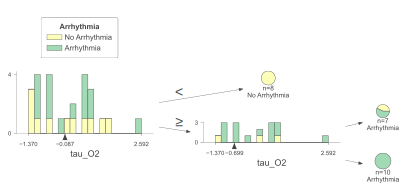

In [34]:
# Visualize XGBoost trees using dtreeviz (new API)
# Reference: https://stackoverflow.com/questions/75576403
import dtreeviz
import numpy as np

# Extract the XGBoost model and scaler from the pipeline
xgb_model = model_arrhythmia.named_steps['xgb']
scaler = model_arrhythmia.named_steps['scaler']

# Scale all features for visualization
X_scaled = scaler.transform(features_df)
y_labels = arrhythmia if isinstance(arrhythmia, np.ndarray) else arrhythmia.values

# Print model info
print("="*80)
print("XGBoost Model Information")
print("="*80)
print(f"Number of trees: {xgb_model.n_estimators}")
print(f"Max depth: {xgb_model.max_depth}")
print(f"Actual trees in booster: {len(xgb_model.get_booster().get_dump())}")

# Create model visualization object using new API (model= keyword required)
tree_idx = 0
viz_model = dtreeviz.model(
    model=xgb_model,
    tree_index=tree_idx,
    X_train=X_scaled,
    y_train=y_labels,
    feature_names=features_df.columns.tolist(),
    class_names=['No Arrhythmia', 'Arrhythmia'],
    target_name='Arrhythmia'
)

# ============================================================
# GRAPH 1: Overall tree structure with all drug distributions
# ============================================================
print(f"\n{'='*80}")
print(f"Tree {tree_idx} - Overall Structure (All Drugs Distribution)")
print(f"{'='*80}")

viz_all = viz_model.view(orientation='LR')
display(viz_all)



## Step 15: Save Models (Optional)

Save the trained models and feature importance DataFrames for later use.


In [ ]:
# Cell 15: Save Models (Optional)
if not XGBOOST_AVAILABLE:
    print("ERROR: XGBoost is not installed. Cannot save models.")
else:
    import joblib

    # Create output directory
    output_dir = PROJECT_ROOT / 'Output' / 'Model_Properties'
    output_dir.mkdir(parents=True, exist_ok=True)

    print("="*80)
    print("SAVING MODELS AND RESULTS")
    print("="*80)

    # Save models
    model_paths = {}
    # Save Arrhythmia and Heart_Damage models
    for target_name, model in [('Arrhythmia', model_arrhythmia), ('Heart_Damage', model_heart_damage)]:
        model_path = output_dir / f'xgb_pkpd_elimination_{target_name}.joblib'
        joblib.dump(model, model_path)
        model_paths[target_name] = model_path
        print(f"  Saved model: {model_path}")
    # Save Concern model (Random Forest)
    if 'model' in results_concern_rf:
        concern_model_path = output_dir / 'random_forest_pkpd_elimination_Concern.joblib'
        joblib.dump(results_concern_rf['model'], concern_model_path)
        model_paths['Concern'] = concern_model_path
        print(f"  Saved model: {concern_model_path}")
    else:
        print("WARNING: Concern model not available in results_concern_rf, not saving.")

    # Save feature importances/coefficients (different models have different structures)
    importance_paths = {}

    # Arrhythmia: XGBoost has feature_importances
    if 'feature_importances' in results_arrhythmia and results_arrhythmia['feature_importances'] is not None:
        importance_path = output_dir / f'xgb_pkpd_elimination_Arrhythmia_feature_importances.csv'
        results_arrhythmia['feature_importances'].to_csv(importance_path, index=False)
        importance_paths['Arrhythmia'] = importance_path
        print(f"  Saved feature importances: {importance_path}")

    # Heart Damage: Gaussian Kernel (SVM) doesn't have feature importances
    if 'feature_importances' in results_heart_damage and results_heart_damage['feature_importances'] is not None:
        importance_path = output_dir / f'xgb_pkpd_elimination_Heart_Damage_feature_importances.csv'
        results_heart_damage['feature_importances'].to_csv(importance_path, index=False)
        importance_paths['Heart_Damage'] = importance_path
        print(f"  Saved feature importances: {importance_path}")
    else:
        print(f"  Heart Damage (Gaussian Kernel): No feature importances available (SVM with RBF kernel)")

    # Concern: Random Forest feature importances
    if 'feature_importances' in results_concern_rf and results_concern_rf['feature_importances'] is not None:
        importance_path = output_dir / f'random_forest_pkpd_elimination_Concern_feature_importances.csv'
        results_concern_rf['feature_importances'].to_csv(importance_path, index=False)
        importance_paths['Concern'] = importance_path
        print(f"  Saved feature importances: {importance_path}")
    else:
        print(f"  Concern: No feature importances available.")

    # Save performance summary
    summary_path = output_dir / 'xgb_pkpd_elimination_performance_summary.csv'
    comparison_df[['Target', 'Mean CV Accuracy', 'Std CV Accuracy',
                   'Mean CV F1-Score', 'Std CV F1-Score', 'Number of Features']].to_csv(summary_path, index=False)
    print(f"  Saved performance summary: {summary_path}")

    print(f"\n✓ All models and results saved to: {output_dir}")
    print("\nSaved files:")
    for target_name in ['Arrhythmia', 'Heart_Damage', 'Concern']:
        if target_name in model_paths:
            print(f"  - {model_paths[target_name].name}")
        else:
            print(f"  - No model file saved for {target_name}")
        if target_name in importance_paths:
            print(f"  - {importance_paths[target_name].name}")
        else:
            print(f"  - No feature importance file saved for {target_name}")
    print(f"  - {summary_path.name}")

SAVING MODELS AND RESULTS
  Saved model: c:\Users\NoahB\Documents\HebrewU Bioengineering\Cardiac_RODEO\Output\Model_Properties\xgb_pkpd_elimination_Arrhythmia.joblib
  Saved model: c:\Users\NoahB\Documents\HebrewU Bioengineering\Cardiac_RODEO\Output\Model_Properties\xgb_pkpd_elimination_Heart_Damage.joblib
  Saved feature importances: c:\Users\NoahB\Documents\HebrewU Bioengineering\Cardiac_RODEO\Output\Model_Properties\xgb_pkpd_elimination_Arrhythmia_feature_importances.csv
  Heart Damage (Gaussian Kernel): No feature importances available (SVM with RBF kernel)
  Saved feature importances: c:\Users\NoahB\Documents\HebrewU Bioengineering\Cardiac_RODEO\Output\Model_Properties\random_forest_pkpd_elimination_Concern_feature_importances.csv
  Saved performance summary: c:\Users\NoahB\Documents\HebrewU Bioengineering\Cardiac_RODEO\Output\Model_Properties\xgb_pkpd_elimination_performance_summary.csv

✓ All models and results saved to: c:\Users\NoahB\Documents\HebrewU Bioengineering\Cardiac_RO

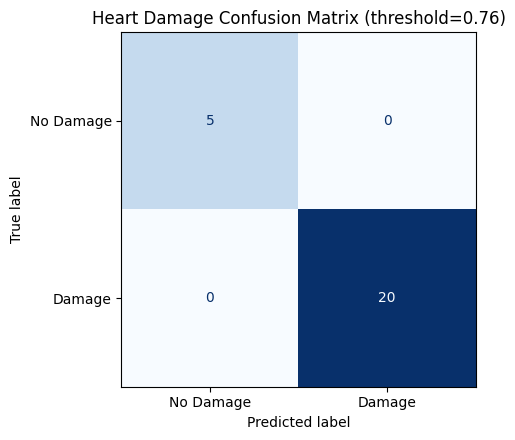


Classification report (threshold = 0.76):
              precision    recall  f1-score   support

   No Damage       1.00      1.00      1.00         5
      Damage       1.00      1.00      1.00        20

    accuracy                           1.00        25
   macro avg       1.00      1.00      1.00        25
weighted avg       1.00      1.00      1.00        25



In [ ]:
# Confusion Matrix — Heart Damage (Aggregated from All 3 Folds, threshold = 0.76)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import StratifiedKFold

threshold = 0.76
cv_hd_cm = StratifiedKFold(n_splits=3, shuffle=True, random_state=21)

print("="*80)
print(f"HEART DAMAGE CONFUSION MATRIX (threshold={threshold:.2f})")
print("="*80)

# Aggregate predictions from all folds
all_y_true = []
all_y_pred = []

for fold_idx, (train_idx, test_idx) in enumerate(cv_hd_cm.split(features_df, heart_damage), start=1):
    X_train, X_test = features_df.iloc[train_idx], features_df.iloc[test_idx]
    if hasattr(heart_damage, 'iloc'):
        y_train, y_test = heart_damage.iloc[train_idx], heart_damage.iloc[test_idx]
    else:
        y_train, y_test = heart_damage[train_idx], heart_damage[test_idx]

    # Match training config: StandardScaler + SVC(probability=True)
    svm_fold = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=40)
    pipeline_fold = Pipeline([
        ('scaler', StandardScaler()),
        ('svm', svm_fold)
    ])
    pipeline_fold.fit(X_train, y_train)

    # Apply threshold to probabilities
    y_prob = pipeline_fold.predict_proba(X_test)[:, 1]
    y_pred = (y_prob >= threshold).astype(int)
    y_true = y_test.astype(int)

    # Collect predictions
    all_y_true.extend(y_true)
    all_y_pred.extend(y_pred)

    print(f"\nFold {fold_idx}: {len(y_test)} samples")

# Convert to arrays
all_y_true = np.array(all_y_true)
all_y_pred = np.array(all_y_pred)

# Compute aggregated confusion matrix
cm = confusion_matrix(all_y_true, all_y_pred)

# Create figure
fig, ax = plt.subplots(figsize=(6, 5))

# Manual plot for better control over labels
im = ax.imshow(cm, interpolation='nearest', cmap='Blues')
ax.figure.colorbar(im, ax=ax)

# Set ticks
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=['No Damage', 'Damage'],
       yticklabels=['No Damage', 'Damage'])

# Rotate y-tick labels to be horizontal
ax.set_yticklabels(['No Damage', 'Damage'], rotation=0, va='center')

# Set axis labels
ax.set_xlabel('Predicted Damage', fontsize=12, fontweight='bold')
ax.set_ylabel('Expected Damage', fontsize=12, fontweight='bold')
ax.set_title(f'Heart Damage Confusion Matrix (threshold={threshold:.2f})\nAggregated from 3 Folds', 
             fontsize=13, fontweight='bold')

# Add text annotations
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black",
                fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Print classification report
print(f"\n{'='*80}")
print("AGGREGATED CLASSIFICATION REPORT (All 3 Folds)")
print(f"{'='*80}")
print(classification_report(all_y_true, all_y_pred, target_names=['No Damage', 'Damage'], zero_division=0))
print(f"\nTotal samples: {len(all_y_true)}")
print(f"✓ Aggregated confusion matrix from all 3 folds displayed.")

## PCA Decision Surface — Heart Damage (RBF SVM)
This view projects features to 2D via PCA, then fits a surrogate RBF SVM in that 2D space to visualize a smooth decision surface. Colors show predicted heart-damage probability; dashed contour marks the 76% threshold.

PCA explained variance: PC1=21.76%, PC2=16.70%


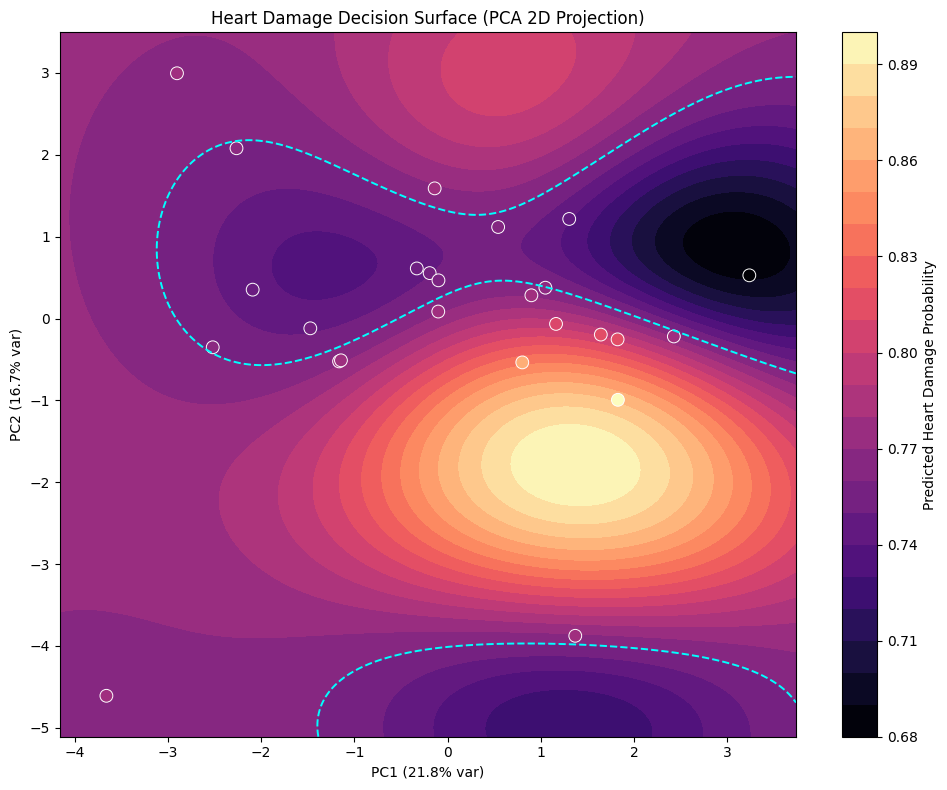

In [21]:
# PCA-based Decision Surface for Heart Damage (surrogate in PCA space)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.svm import SVC

# Prepare input matrix using pipeline scaler if present
try:
    scaler_hd = model_heart_damage.named_steps.get('scaler', None)
except Exception:
    scaler_hd = None

if scaler_hd is not None:
    X_in = scaler_hd.transform(features_df)
else:
    X_in = features_df.values

# Fit PCA to 2D
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_in)
expl = pca.explained_variance_ratio_
print(f"PCA explained variance: PC1={expl[0]:.2%}, PC2={expl[1]:.2%}")

# Train a surrogate SVM in PCA space for visualization
svm_pca = SVC(kernel='rbf', probability=True, C=1.0, gamma='scale', random_state=42)
svm_pca.fit(X_pca, heart_damage)

# Build grid in PCA space
pad = 0.5
pc1_min, pc1_max = X_pca[:, 0].min() - pad, X_pca[:, 0].max() + pad
pc2_min, pc2_max = X_pca[:, 1].min() - pad, X_pca[:, 1].max() + pad
res = 300
xx, yy = np.meshgrid(np.linspace(pc1_min, pc1_max, res), np.linspace(pc2_min, pc2_max, res))
Z = svm_pca.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1].reshape(xx.shape)

# Plot decision surface
plt.figure(figsize=(10, 8))
cont = plt.contourf(xx, yy, Z, levels=25, cmap='magma')
cbar = plt.colorbar(cont)
cbar.set_label('Predicted Heart Damage Probability')

# Overlay drugs colored by surrogate probability
probs_pca = svm_pca.predict_proba(X_pca)[:, 1]
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=probs_pca, cmap='magma', edgecolor='white', s=85, linewidth=0.7)

# 76% threshold contour (if exists in range)
try:
    plt.contour(xx, yy, Z, levels=[0.76], colors='cyan', linestyles='--', linewidths=1.4)
except Exception as e:
    print("Could not draw 76% contour:", e)

plt.title('Heart Damage Decision Surface (PCA 2D Projection)')
plt.xlabel(f"PC1 ({expl[0]*100:.1f}% var)")
plt.ylabel(f"PC2 ({expl[1]*100:.1f}% var)")
plt.tight_layout()
plt.show()

## Decision Boundary (Feature Slice) — Heart Damage
This view varies two real features on a grid (others fixed at median) and plots the model's predicted probability as a smooth surface. Points show drugs colored by predicted risk; dashed red marks the 76% threshold.

## SHAP Feature Importance — Heart Damage (RBF SVM)
Because the Heart Damage model uses a non-linear RBF SVM, we use SHAP KernelExplainer to estimate per-feature contributions. The plots below show the impact of all features across drugs (violin) and the overall mean absolute importance (bar).